
#       Imports       



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import VGG16_Weights
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import numpy as np
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM,GradCAMpp
from torchcam.utils import overlay_mask
from torchvision.models import vgg16,alexnet
from torchvision.models import resnet18, ResNet18_Weights,vit_b_16
from torchvision.models import googlenet, GoogLeNet_Weights,AlexNet_Weights,ViT_B_16_Weights
from torchvision.datasets import ImageFolder
import timm
from tqdm import tqdm
import mediapipe as mp
import cv2
import json
import random
import math
from torch_geometric.data import Dataset, Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.loader import DataLoader
import matplotlib.cm as cm


/home/prj7971/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [ ]:
def load_model(architecture: str, num_classes: int, model_path: str, device="cuda"):
    """
    Load a pre-trained model with a custom classifier and saved weights.

    Args:
        architecture (str): 'vgg16', 'resnet18', 'googlenet', 'alexnet', 'vit', or 'dinov2'
        num_classes (int): Number of output classes
        model_path (str): Path to the .pth file with weights
        device (str): 'cuda' or 'cpu'

    Returns:
        model (torch.nn.Module): The model loaded with weights, ready for inference
    """
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    arch = architecture.lower()
    state_dict = torch.load(model_path, map_location=device)

    if arch == "vgg16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif arch == "resnet18":
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif arch == "googlenet":
        has_aux = any("aux1." in k or "aux2." in k for k in state_dict.keys())
        model = googlenet(weights=None, aux_logits=has_aux, init_weights=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif arch == "alexnet":
        model = alexnet(weights=AlexNet_Weights.DEFAULT)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif arch == "simplecnn":
        model = SimpleCNN(num_classes=num_classes)

    elif arch == "vit":
        model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in model.parameters():
            param.requires_grad = False
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

    elif arch == "dinov2":
        model = timm.create_model("vit_base_patch14_dinov2.lvd142m", pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.head = nn.Linear(model.num_features, num_classes)

    elif arch == "posegnn":

        model = PoseGNN()

    else:
        raise ValueError(f"Unsupported architecture: {architecture}")

    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [ ]:
def confusion_matrix_and_stats(model_path, model_name, num_classes, test_loader, device, class_names):
    """
    Loads a model and evaluates it on the test set.
    Plots confusion matrix and prints classification report.

    Args:
        model_path (str): Path to the model weights (.pth file).
        model_name (str): Architecture name (e.g., 'vgg16').
        num_classes (int): Number of output classes.
        test_loader (DataLoader): DataLoader for the test set.
        device (torch.device): The device to run evaluation on.
        class_names (list): List of class names (strings), in order of class index.
    """
    model = load_model(model_name, num_classes=num_classes, model_path=model_path)
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on Test Set')
    plt.tight_layout()
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0)
    print("\nClassification Report:\n")
    print(report)


In [ ]:
def show_gradcam_row_general(model, arch="resnet", n=5, start=0, method="gradcam"):
    # Select target layer based on architecture
    if arch == "resnet":
        target_layer = "layer4.1.conv2"
    elif arch == "vgg":
        target_layer = "features.29"
    elif arch == "alexnet":
        target_layer = "features.11"
    elif arch == "googlenet":
        target_layer = "inception5b.branch3.1.conv"
    elif arch == "custom":
        target_layer = "features.6"
    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    # Choose CAM method
    if method.lower() == "gradcam":
        cam_extractor = GradCAM(model, target_layer=target_layer)
    elif method.lower() in ["gradcam++", "gradcampp"]:
        cam_extractor = GradCAMpp(model, target_layer=target_layer)
    else:
        raise ValueError(f"Unsupported CAM method: {method}")

    # Get class labels
    class_names = list(full_train_dataset.class_to_idx.keys())

    fig, axes = plt.subplots(1, n, figsize=(n * 4, 4))

    for i in range(n):
        idx = start + i
        img_tensor, label = test_dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad = True

        # Forward pass
        output = model(input_tensor)
        if isinstance(output, tuple):  # GoogLeNet returns (output, aux)
            output = output[0]
        pred_class = output.argmax(dim=1).item()

        # Extract CAM
        activation_map = cam_extractor(pred_class, output)[0].cpu()

        # Prepare images
        original_image = to_pil_image(img_tensor)
        heatmap = to_pil_image(activation_map, mode='F')
        result = overlay_mask(original_image, heatmap, alpha=0.5)

        # Display result
        axes[i].imshow(result)
        title = f"#{idx}\nPred: {class_names[pred_class]}\nTrue: {class_names[label]}"
        if pred_class != label:
            axes[i].set_title(title, fontsize=10, color='red')
        else:
            axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def find_errors_for_grad_cam(model):
    incorrect_samples = []


    for i in range(len(test_dataset)):
        img_tensor, true_label = test_dataset[i]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad_()

        output = model(input_tensor)
        pred_label = output.argmax(dim=1).item()

        if pred_label != true_label:
            incorrect_samples.append((i, img_tensor, true_label, pred_label))

    print(f"Found {len(incorrect_samples)} incorrect predictions.")

    return incorrect_samples


In [ ]:
def show_grad_cam_errors_general(model, incorrect_samples, arch="vgg", method="gradcam", batch_size=5, start=0):
    """
    Visualizes Grad-CAM overlays for misclassified samples.

    Args:
        model (torch.nn.Module): Trained CNN model.
        incorrect_samples (list of tuples): List of (index, image_tensor, true_label, predicted_label).
        arch (str): Model architecture name.
        method (str): 'gradcam' or 'gradcam++'.
        batch_size (int): Number of samples to visualize.
        start (int): Starting index in the incorrect_samples list.
    """

    # Determine target layer based on architecture
    if arch == "resnet":
        target_layer = "layer4.1.conv2"
    elif arch == "vgg":
        target_layer = "features.29"
    elif arch == "alexnet":
        target_layer = "features.11"
    elif arch == "googlenet":
        target_layer = "inception5b.branch3.1.conv"
    elif arch == "simple":
        target_layer = "features.6"  # Change this according to your model definition
    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    # Select CAM method
    if method.lower() == "gradcam":
        cam_extractor = GradCAM(model, target_layer=target_layer)
    elif method.lower() in ["gradcam++", "gradcampp"]:
        cam_extractor = GradCAMpp(model, target_layer=target_layer)
    else:
        raise ValueError(f"Unsupported CAM method: {method}")

    # Get class labels
    class_names = list(full_train_dataset.class_to_idx.keys())

    # Set up figure
    end = min(start + batch_size, len(incorrect_samples))
    fig, axes = plt.subplots(1, end - start, figsize=((end - start) * 4, 4))

    # Handle single subplot case
    if end - start == 1:
        axes = [axes]

    # Visualize each error sample
    for idx_in_batch, (i, img_tensor, true_label, pred_label) in enumerate(incorrect_samples[start:end]):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad_()

        # Forward pass
        output = model(input_tensor)
        if isinstance(output, tuple):  # for models like GoogLeNet
            output = output[0]
        prob = torch.nn.functional.softmax(output, dim=1)[0, pred_label].item()

        # Compute CAM
        cam = cam_extractor(pred_label, output)[0].cpu()
        original = to_pil_image(img_tensor)
        heatmap = to_pil_image(cam, mode='F')
        result = overlay_mask(original, heatmap, alpha=0.5)

        # Display result
        ax = axes[idx_in_batch]
        ax.imshow(result)
        ax.set_title(
            f"#{i}\nPred: {class_names[pred_label]} ({prob:.1%})\nTrue: {class_names[true_label]}",
            fontsize=9,
            color='red' if pred_label != true_label else 'black'
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Define a class to add Gaussian noise to tensors
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0., 1.)

# Evaluate the model accuracy under a certain noise level
def evaluate_model_with_noise(model_path: str, architecture: str, test_dir: str, num_classes: int, class_names: list, noise_std=0.1, batch_size=32, device="cuda"):

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    if architecture == "dinov2":
        noisy_transform = transforms.Compose([
        transforms.Resize((518, 518)),
        transforms.ToTensor(),
        AddGaussianNoise(0., noise_std),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    else:
    # Define noisy transform
        noisy_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            AddGaussianNoise(0., noise_std),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

    # Create noisy test dataset and dataloader
    noisy_test_dataset = ImageFolder(test_dir, transform=noisy_transform)
    noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)

    # Load model
    model = load_model(architecture, num_classes=num_classes, model_path=model_path, device=device)

    # Evaluate accuracy
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in noisy_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"[{os.path.basename(model_path)}] Accuracy on noisy test set (std={noise_std}): {acc:.2f}%")
    return acc

# Return accuracy values for a range of noise levels (no plot)
def get_accuracy_curve(model_path: str, architecture: str, test_dir: str, num_classes: int, class_names: list, noise_levels, batch_size=32, device="cuda"):
    accuracies = []
    for noise_std in noise_levels:
        acc = evaluate_model_with_noise(
            model_path=model_path,
            architecture=architecture,
            test_dir=test_dir,
            num_classes=num_classes,
            class_names=class_names,
            noise_std=noise_std,
            batch_size=batch_size,
            device=device
        )
        accuracies.append(acc)
    return accuracies

# Run on all models and plot one shared figure
def run_on_all_models(models_folder, test_dir, num_classes, class_names, noise_levels=[0.0, 0.05, 0.1, 0.15, 0.2], batch_size=32, device="cuda"):
    plt.figure(figsize=(10, 6))
    for filename in os.listdir(models_folder):
        if filename.endswith(".pth"):
            model_path = os.path.join(models_folder, filename)

            if filename.startswith("best_"):
                architecture = filename.replace("best_", "").split("_")[0]
            if architecture == "simplecnn.pth":
                architecture = "simplecnn"

            print(f"Running {architecture}...")

            accuracies = get_accuracy_curve(
                model_path=model_path,
                architecture=architecture,
                test_dir=test_dir,
                num_classes=num_classes,
                class_names=class_names,
                noise_levels=noise_levels,
                batch_size=batch_size,
                device=device
            )

            plt.plot(noise_levels, accuracies, marker='o', label=architecture)

    plt.title("Accuracy vs. Gaussian Noise Level (All Models)")
    plt.xlabel("Gaussian Noise Std")
    plt.ylabel("Accuracy (%)")
    plt.xticks(noise_levels)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


In [ ]:
def augment_keypoints(keypoints, jitter_std=0.02, scale_range=(0.9, 1.1), rotation_deg=15):
    """
    Apply augmentations to keypoints:
    - Jittering (small Gaussian noise)
    - Scaling
    - Rotation around the center of the keypoints
    """
    keypoints = torch.tensor(keypoints, dtype=torch.float32)  # shape: [num_points, 2]

    # Center the keypoints (subtract mean)
    center = keypoints.mean(dim=0)
    keypoints_centered = keypoints - center

    # Apply jittering (Gaussian noise)
    jitter = torch.randn_like(keypoints_centered) * jitter_std
    keypoints_centered += jitter

    # Apply random scaling
    scale = random.uniform(*scale_range)
    keypoints_centered *= scale

    # Apply rotation
    theta = math.radians(random.uniform(-rotation_deg, rotation_deg))
    rotation_matrix = torch.tensor([
        [math.cos(theta), -math.sin(theta)],
        [math.sin(theta),  math.cos(theta)]
    ], dtype=torch.float32)
    keypoints_centered = torch.matmul(keypoints_centered, rotation_matrix.T)

    # Revert centering
    augmented_keypoints = keypoints_centered + center
    return augmented_keypoints.tolist()


In [ ]:
def show_vit_dino_gradcam_row(model, arch="vit", n=5, start=0, method="gradcam"):
    # Select target layer
    if arch == "vit":
        target_layer = "encoder.layers.encoder_layer_11.ln_1"
    elif arch == "dino":
        target_layer = "blocks.11.norm2"
    else:
        raise ValueError("Only ViT and DINO are supported by this function")

    # Initialize CAM extractor
    if method.lower() == "gradcam":
        cam_extractor = GradCAM(model, target_layer=target_layer)
    elif method.lower() in ["gradcam++", "gradcampp"]:
        cam_extractor = GradCAMpp(model, target_layer=target_layer)
    else:
        raise ValueError(f"Unsupported CAM method: {method}")

    class_names = list(full_train_dataset.class_to_idx.keys())
    fig, axes = plt.subplots(1, n, figsize=(n * 4, 4))

    for i in range(n):
        idx = start + i
        img_tensor, label = test_dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad = True

        # Forward pass
        output = model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]
        pred_class = output.argmax(dim=1).item()

        # Get CAM
        cam = cam_extractor(pred_class, output)[0].cpu()
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # Resize CAM to match image
        cam_resized = resize(cam.unsqueeze(0), size=img_tensor.shape[1:], interpolation=InterpolationMode.BILINEAR).squeeze(0)

        # Convert to heatmap (RGB only)
        heatmap = cm.jet(cam_resized.numpy())[..., :3]
        heatmap = (heatmap * 255).astype(np.uint8)
        heatmap = Image.fromarray(heatmap)

        # Convert image and blend
        original_image = to_pil_image(img_tensor)
        result = Image.blend(original_image.convert("RGB"), heatmap.convert("RGB"), alpha=0.5)

        # Plot
        axes[i].imshow(result)
        title = f"#{idx}\nPred: {class_names[pred_class]}\nTrue: {class_names[label]}"
        if pred_class != label:
            axes[i].set_title(title, fontsize=10, color='red')
        else:
            axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def show_pose_explainer_row(dataset, explainer, start=0, n=5, threshold=0.0):
    """
    Display n examples from the dataset in a row with the explainer overlay.
    Each edge is drawn with line width and transparency proportional to its weight,
    and edges below the threshold are filtered out.

    Parameters:
    - dataset: PoseGraphDataset instance (train=False).
    - explainer: Explainer object initialized with GNNExplainer.
    - start: Starting index in the dataset.
    - n: Number of images to display in the row.
    - threshold: Weight threshold; only edges with weight > threshold are shown.
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # Get device from the model's parameters
    device = next(explainer.model.parameters()).device

    # Create a figure with n subplots in one row
    fig, axes = plt.subplots(1, n, figsize=(n * 4, 4))
    for i in range(n):
        idx = start + i
        data = dataset[idx]

        # Move data to device and set up batch
        data = data.to(device)
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

        # Generate explanation for this sample
        explanation = explainer(
            x=data.x,
            edge_index=data.edge_index,
            batch=data.batch,
            target=data.y,
        )
        edge_mask = explanation.edge_mask.detach().cpu().numpy()  # [num_edges]

        # Load the original image
        img = Image.open(data.img_path)
        w, h = img.size

        # Convert relative keypoints [0..1] to pixel coordinates
        pts_rel = data.orig_kp.cpu().numpy()     # shape [33,2]
        pts = np.stack([pts_rel[:,0] * w, pts_rel[:,1] * h], axis=1)

        ax = axes[i]
        ax.imshow(img)
        ax.scatter(pts[:,0], pts[:,1], c='yellow', s=30, edgecolors='black')

        # Draw edges with weight-based styling
        for (u, v), weight in zip(POSE_EDGES, edge_mask):
            if weight <= threshold:
                continue
            x0, y0 = pts[u]
            x1, y1 = pts[v]
            ax.plot([x0, x1], [y0, y1],
                    linewidth=2 * weight + 0.5,
                    alpha=float(weight),
                    color='red')
        class_names = list(full_train_dataset.class_to_idx.keys())
        # Compute predicted class and get names
        with torch.no_grad():
            pred_idx = explainer.model(data.x, data.edge_index, data.batch).argmax(dim=1).item()
            true_idx = data.y.item()
        pred_name = class_names[pred_idx]
        true_name = class_names[true_idx]

        # Set title using class names
        title = f"#{idx}\nPred: {pred_name}\nTrue: {true_name}"
        ax.set_title(title, fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_posegnn_with_noise(model, dataset, noise_std=0.0, batch_size=32, device="cuda"):
    from torch_geometric.loader import DataLoader
    from sklearn.metrics import classification_report
    import numpy as np

    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # Apply Gaussian noise to node features if needed
    if noise_std > 0:
        noisy_dataset = []
        for data in dataset:
            data = data.clone()
            data.x += torch.randn_like(data.x) * noise_std
            noisy_dataset.append(data)
    else:
        noisy_dataset = dataset

    loader = DataLoader(noisy_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    correct = np.sum(np.array(all_preds) == np.array(all_labels))
    acc = 100 * correct / len(all_labels)

    print(f"Accuracy on noisy test set (std={noise_std}): {acc:.2f}%")
    return acc


def plot_accuracy_vs_noise_posegnn(
    model_path: str,
    model_class,  # class, e.g., PoseGNN
    test_dataset,  # instance of PoseGraphDataset
    noise_levels=[0.0, 0.05, 0.1, 0.15, 0.2],
    batch_size=32,
    device="cuda"
):
    import matplotlib.pyplot as plt
    import torch

    # Load model
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    accuracies = []
    for noise_std in noise_levels:
        acc = evaluate_posegnn_with_noise(
            model=model,
            dataset=test_dataset,
            noise_std=noise_std,
            batch_size=batch_size,
            device=device
        )
        accuracies.append(acc)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(noise_levels, accuracies, marker='o', linestyle='-', color='teal', linewidth=2)
    plt.title("PoseGNN Accuracy vs. Gaussian Noise", fontsize=14)
    plt.xlabel("Gaussian Noise Std", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(noise_levels)
    plt.tight_layout()
    plt.show()


In [ ]:


# --------------------------------------------------
# 1. Helper functions: rollout computation, resizing, overlay
# --------------------------------------------------
def compute_gradcam_rollout(attns, grads):
    """
    Compute Grad-CAM–style rollout from attention maps and their gradients.
    """
    B, H, N, _ = attns[0].shape
    # Initialize identity for rollout
    rollout = torch.eye(N, device=attns[0].device) \
                   .unsqueeze(0).repeat(B, 1, 1)
    for attn, grad in zip(attns, grads):
        # Average gradient over attention heads
        weights = grad.mean(dim=1, keepdim=True)
        # Weighted combination of attention
        cam = (attn * weights).sum(dim=1)
        cam = F.relu(cam)
        cam = cam / (cam.sum(dim=-1, keepdim=True) + 1e-6)
        rollout = torch.bmm(cam, rollout)
    return rollout

def resize_rollout_to_image(rollout_row, image_size):
    """
    Convert a single rollout vector into a 2D heatmap and resize to image_size.
    """
    arr = rollout_row.cpu().numpy()
    h = w = int(np.sqrt(arr.shape[0]))
    arr = arr.reshape(h, w)
    arr = cv2.resize(arr, image_size)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

def overlay_heatmap_on_image(image, heatmap, alpha=0.5):
    """
    Overlay the heatmap onto the PIL image with given transparency.
    """
    img_np = np.array(image.resize(heatmap.shape[::-1])) / 255.0
    hm_uint8 = np.uint8(255 * heatmap)
    hm_color = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB) / 255.0
    return np.clip(hm_color * alpha + img_np * (1 - alpha), 0, 1)

# --------------------------------------------------
# 2. Main function: Grad-CAM on conv_proj layer
# --------------------------------------------------
def show_conv_proj_gradcam_vit(model, test_dataset, idx_to_class, device, n=5, start=0):
    """
    Vanilla Grad-CAM on ViT's conv_proj layer using forward‐hook + tensor.register_hook().
    """
    import torch.nn.functional as F

    model.eval()
    fig, axes = plt.subplots(1, n, figsize=(n*4,4))

    for i in range(n):
        # lists to store feature maps and their gradients
        fmap_list = []
        fmap_grad_list = []

        # forward-hook: capture conv_proj output
        def forward_conv_hook(module, inp, out):
            fmap_list.append(out)       # out: (1, C, H, W)
            out.retain_grad()           # enable gradient tracking on this tensor
            out.register_hook(lambda grad: fmap_grad_list.append(grad))

        # register the hook
        h_f = model.conv_proj.register_forward_hook(forward_conv_hook)

        # prepare input tensor
        img, label = test_dataset[start + i]
        inp = img.unsqueeze(0).to(device).requires_grad_()

        # forward + backward on the predicted class score
        out = model(inp)
        pred = out.argmax(dim=1).item()
        score = out[0, pred]
        model.zero_grad()
        score.backward()

        # remove the hook
        h_f.remove()

        # retrieve fmap and fmap_grad from storage
        fmap      = fmap_list[0]        # (1, C, H, W)
        fmap_grad = fmap_grad_list[0]   # (1, C, H, W)

        # 4. Grad-CAM computation
        weights = fmap_grad.mean(dim=(2,3), keepdim=True)   # (1, C, 1, 1)
        cam     = (weights * fmap).sum(dim=1, keepdim=True) # (1,1,H,W)
        cam     = F.relu(cam).squeeze().cpu().detach().numpy()  # (H,W)

        # normalize & resize to 224×224
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (224,224))

        # overlay heatmap on original image
        orig = to_pil_image(img.cpu())
        heatmap = np.uint8(255 * cam)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[..., ::-1] / 255.0
        overlay = heatmap * 0.5 + np.array(orig)/255.0 * 0.5

        # probability
        prob = F.softmax(out, dim=1)[0, pred].item()

        # display result
        title = (f"#{start+i}\n  Pred: {idx_to_class[pred]}\n"
                 f"True: {idx_to_class[label]}")
        ax = axes[i]
        ax.imshow(overlay)
        ax.set_title(title, color=('red' if pred!=label else 'black'))
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# --------------------------------------------------
# 1. Helper functions: rollout computation, resizing
# --------------------------------------------------
def compute_gradcam_rollout(attns, grads):
    """
    Compute Grad-CAM–style rollout from attention maps and their gradients.
    """
    B, H, N, _ = attns[0].shape
    rollout = torch.eye(N, device=attns[0].device) \
               .unsqueeze(0).repeat(B, 1, 1)
    for attn, grad in zip(attns, grads):
        weights = grad.mean(dim=1, keepdim=True)
        cam = (attn * weights).sum(dim=1)
        cam = F.relu(cam)
        cam = cam / (cam.sum(dim=-1, keepdim=True) + 1e-6)
        rollout = torch.bmm(cam, rollout)
    return rollout

def resize_cam(cam, size=(518, 518)):
    """
    Normalize a CAM map to [0,1], resize to 'size', and return numpy array.
    """
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam_np = cv2.resize(cam.cpu().numpy(), size)
    return cam_np

# --------------------------------------------------
# 2. Main function: Grad-CAM on DINOv2 patch embedding
# --------------------------------------------------
def show_dinov2_gradcam(
    model,
    test_dataset,
    idx_to_class,
    device,
    n=5,
    start=0,
    threshold=0.3
):
    """
    Perform Grad-CAM on DINOv2's patch_embed.proj layer.
    Overlays heatmap on original image at 518×518 resolution.
    """
    model.eval()
    fig, axes = plt.subplots(1, n, figsize=(n*4,4))

    for i in range(n):
        fmap_list, grad_list = [], []

        # forward-hook on patch embedding projection
        def hook_fn(module, inp, out):
            fmap_list.append(out)      # out: (1, C, H_p, W_p)
            out.retain_grad()
            out.register_hook(lambda g: grad_list.append(g))

        handle = model.patch_embed.proj.register_forward_hook(hook_fn)

        # forward + backward
        img, label = test_dataset[start + i]
        inp = img.unsqueeze(0).to(device).requires_grad_()
        out = model(inp)
        pred  = out.argmax(dim=1).item()
        score = out[0, pred]
        model.zero_grad()
        score.backward()

        handle.remove()

        # compute raw CAM
        fmap      = fmap_list[0]      # (1, C, Hp, Wp)
        fmap_grad = grad_list[0]      # same shape
        weights   = fmap_grad.mean(dim=(2,3), keepdim=True)   # (1,C,1,1)
        cam       = (weights * fmap).sum(dim=1).squeeze(0)     # (Hp, Wp)
        cam       = F.relu(cam).cpu().detach()

        # resize & normalize to 518×518
        cam_np = resize_cam(cam, size=(518, 518))

        # threshold low‐value regions
        cam_np[cam_np < threshold] = 0.0

        # overlay on original
        orig = to_pil_image(img.cpu()).resize((518, 518))
        ax = axes[i]
        ax.imshow(orig)
        ax.imshow(cam_np, cmap='jet', alpha=0.6)

        # title
        prob = F.softmax(out, dim=1)[0, pred].item()
        ax.set_title(
            f"#{start+i}\n"
            f"Pred: {idx_to_class[pred]}\n"
            f"True: {idx_to_class[label]}\n",
            fontsize=10,
            color=('red' if pred!=label else 'black')
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Models - CNN

## ========================================     



##       1. VGG16 Model

## ========================================     




We trained the model with different epoch counts to observe how training duration affects performance and convergence. This helped me detect underfitting or overfitting and choose an appropriate training length for optimal results.

### ------------------------------------------------------------------------------------------
### 1.1 - 10 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
# Dataset class
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TEST", transform=transform_eval)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(full_train_dataset.class_to_idx)

# VGG16 model with updated weights syntax
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TEST", transform=transform_eval)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(full_train_dataset.class_to_idx)

# VGG16 model with updated weights syntax
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 10
best_val_acc = 0.0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg_yoga_10e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")



Running on: cuda
Epoch 1/10 | Train Loss: 1.0239 | Train Acc: 60.42% | Val Acc: 79.17%
Epoch 2/10 | Train Loss: 0.3351 | Train Acc: 89.12% | Val Acc: 89.35%
Epoch 3/10 | Train Loss: 0.1775 | Train Acc: 95.83% | Val Acc: 86.11%
Epoch 4/10 | Train Loss: 0.0710 | Train Acc: 98.38% | Val Acc: 87.96%
Epoch 5/10 | Train Loss: 0.0571 | Train Acc: 98.50% | Val Acc: 87.50%
Epoch 6/10 | Train Loss: 0.0378 | Train Acc: 99.07% | Val Acc: 85.65%
Epoch 7/10 | Train Loss: 0.0202 | Train Acc: 99.42% | Val Acc: 87.04%
Epoch 8/10 | Train Loss: 0.0125 | Train Acc: 99.77% | Val Acc: 86.11%
Epoch 9/10 | Train Loss: 0.0095 | Train Acc: 99.54% | Val Acc: 86.11%
Epoch 10/10 | Train Loss: 0.0304 | Train Acc: 99.77% | Val Acc: 87.04%



 Final Test Accuracy: 93.62%


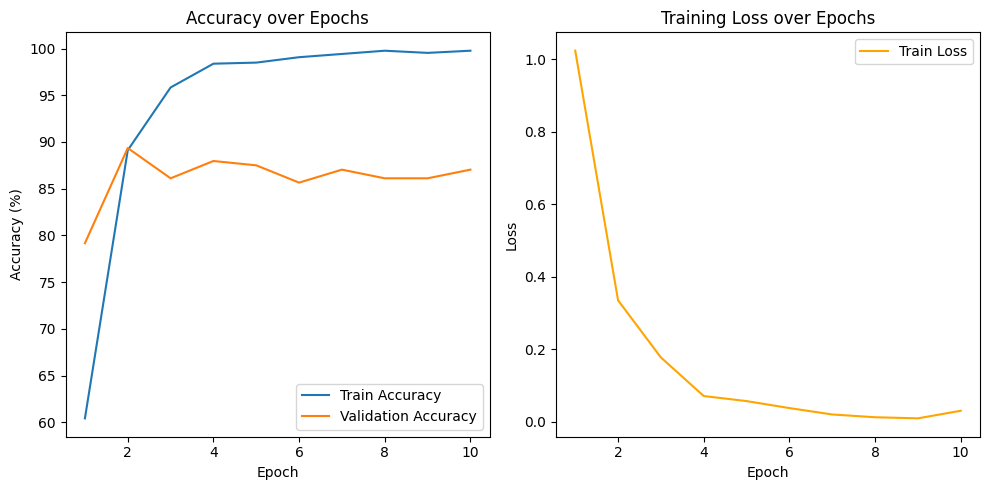

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_vgg_yoga_10e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")

# Plot results
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### ------------------------------------------------------------------------------------------
### 1.2 - 30 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Dataset class
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TEST", transform=transform_eval)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(full_train_dataset.class_to_idx)

# VGG16 model with updated weights syntax
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 30
best_val_acc = 0.0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg_yoga_30e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")



Running on: cuda
Epoch 1/30 | Train Loss: 0.9862 | Train Acc: 60.30% | Val Acc: 86.57%
Epoch 2/30 | Train Loss: 0.2996 | Train Acc: 90.05% | Val Acc: 89.35%
Epoch 3/30 | Train Loss: 0.2000 | Train Acc: 93.75% | Val Acc: 85.65%
Epoch 4/30 | Train Loss: 0.1041 | Train Acc: 97.57% | Val Acc: 89.81%
Epoch 5/30 | Train Loss: 0.0418 | Train Acc: 98.84% | Val Acc: 89.35%
Epoch 6/30 | Train Loss: 0.0267 | Train Acc: 99.42% | Val Acc: 88.89%
Epoch 7/30 | Train Loss: 0.0252 | Train Acc: 99.54% | Val Acc: 87.96%
Epoch 8/30 | Train Loss: 0.0178 | Train Acc: 99.65% | Val Acc: 89.81%
Epoch 9/30 | Train Loss: 0.0156 | Train Acc: 99.65% | Val Acc: 89.81%
Epoch 10/30 | Train Loss: 0.0188 | Train Acc: 99.54% | Val Acc: 87.04%
Epoch 11/30 | Train Loss: 0.0123 | Train Acc: 99.65% | Val Acc: 89.35%
Epoch 12/30 | Train Loss: 0.0049 | Train Acc: 99.88% | Val Acc: 89.81%
Epoch 13/30 | Train Loss: 0.0092 | Train Acc: 99.77% | Val Acc: 87.96%
Epoch 14/30 | Train Loss: 0.0068 | Train Acc: 99.77% | Val Acc: 85.65


 Final Test Accuracy: 94.47%


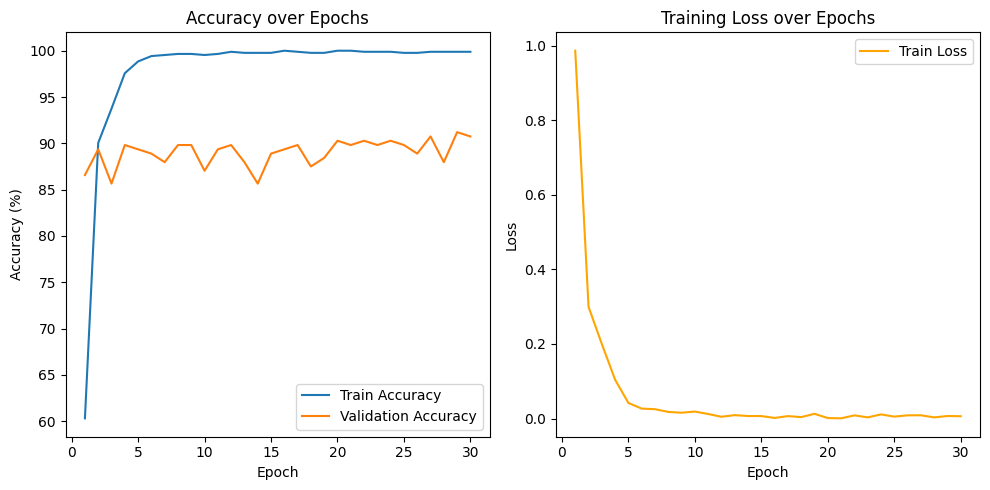

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_vgg_yoga_30e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")

# Plot results
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

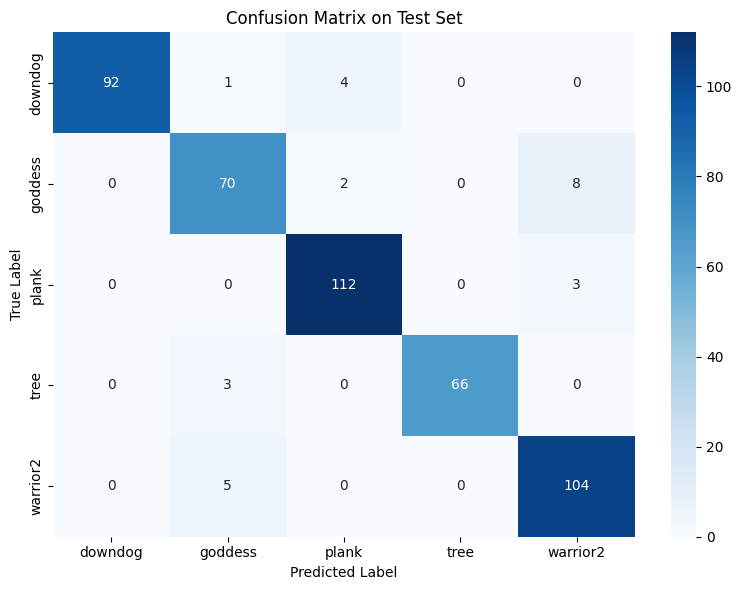


Classification Report:

              precision    recall  f1-score   support

     downdog     1.0000    0.9485    0.9735        97
     goddess     0.8861    0.8750    0.8805        80
       plank     0.9492    0.9739    0.9614       115
        tree     1.0000    0.9565    0.9778        69
    warrior2     0.9043    0.9541    0.9286       109

    accuracy                         0.9447       470
   macro avg     0.9479    0.9416    0.9444       470
weighted avg     0.9460    0.9447    0.9449       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_vgg_yoga_30e.pth",
    model_name="vgg16",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)


### ------------------------------------------------------------------------------------------
### 1.3 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Dataset class
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TEST", transform=transform_eval)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(full_train_dataset.class_to_idx)

# VGG16 model with updated weights syntax
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
best_val_acc = 0.0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg_yoga_50e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")



Running on: cuda
Epoch 1/50 | Train Loss: 1.0622 | Train Acc: 61.11% | Val Acc: 79.17%
Epoch 2/50 | Train Loss: 0.3144 | Train Acc: 89.93% | Val Acc: 83.33%
Epoch 3/50 | Train Loss: 0.1297 | Train Acc: 96.41% | Val Acc: 84.26%
Epoch 4/50 | Train Loss: 0.0738 | Train Acc: 98.26% | Val Acc: 85.19%
Epoch 5/50 | Train Loss: 0.0388 | Train Acc: 99.19% | Val Acc: 83.33%
Epoch 6/50 | Train Loss: 0.0146 | Train Acc: 99.88% | Val Acc: 88.43%
Epoch 7/50 | Train Loss: 0.0173 | Train Acc: 99.42% | Val Acc: 86.11%
Epoch 8/50 | Train Loss: 0.0075 | Train Acc: 99.88% | Val Acc: 86.11%
Epoch 9/50 | Train Loss: 0.0033 | Train Acc: 100.00% | Val Acc: 87.04%
Epoch 10/50 | Train Loss: 0.0030 | Train Acc: 100.00% | Val Acc: 87.96%
Epoch 11/50 | Train Loss: 0.0023 | Train Acc: 100.00% | Val Acc: 87.50%
Epoch 12/50 | Train Loss: 0.0014 | Train Acc: 100.00% | Val Acc: 87.96%
Epoch 13/50 | Train Loss: 0.0030 | Train Acc: 100.00% | Val Acc: 87.96%
Epoch 14/50 | Train Loss: 0.0009 | Train Acc: 100.00% | Val Acc:


 Final Test Accuracy: 94.47%


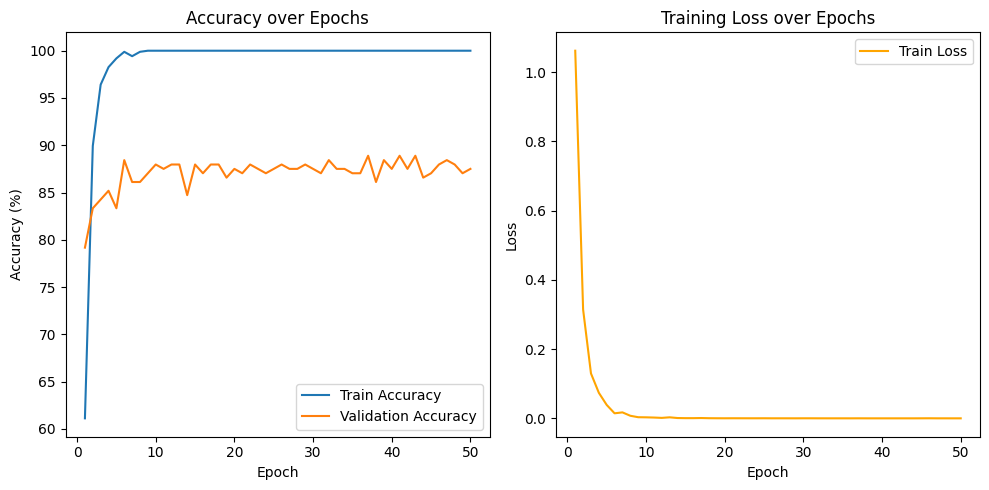

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_vgg_yoga_50e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")

# Plot results
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

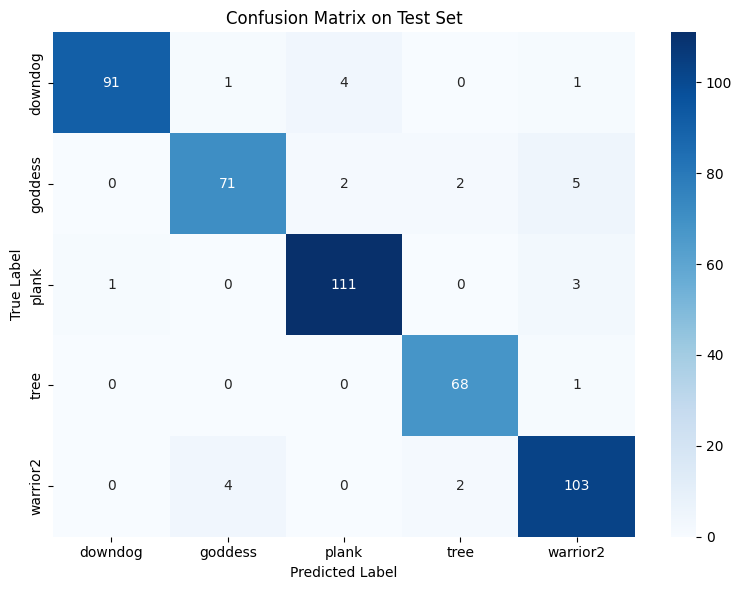


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9891    0.9381    0.9630        97
     goddess     0.9342    0.8875    0.9103        80
       plank     0.9487    0.9652    0.9569       115
        tree     0.9444    0.9855    0.9645        69
    warrior2     0.9115    0.9450    0.9279       109

    accuracy                         0.9447       470
   macro avg     0.9456    0.9443    0.9445       470
weighted avg     0.9453    0.9447    0.9446       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_vgg_yoga_50e.pth",
    model_name="vgg16",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)


### ------------------------------------------------------------------------------------------
### 1.4 - 50 Epochs - Full Training
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Dataset class
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Augmentations and normalization
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("./yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(full_train_dataset.class_to_idx)

# Load VGG16 and enable full fine-tuning
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

# Replace the classifier head
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Loss and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training function
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg_50e_fix.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Epoch 1/50 | Train Loss: 1.2161 | Train Acc: 49.07% | Val Acc: 79.63%
Epoch 2/50 | Train Loss: 0.5084 | Train Acc: 83.91% | Val Acc: 84.72%
Epoch 3/50 | Train Loss: 0.2355 | Train Acc: 92.25% | Val Acc: 87.50%
Epoch 4/50 | Train Loss: 0.1703 | Train Acc: 95.25% | Val Acc: 88.89%
Epoch 5/50 | Train Loss: 0.1041 | Train Acc: 96.53% | Val Acc: 88.43%
Epoch 6/50 | Train Loss: 0.0692 | Train Acc: 97.80% | Val Acc: 90.28%
Epoch 7/50 | Train Loss: 0.0450 | Train Acc: 98.73% | Val Acc: 91.67%
Epoch 8/50 | Train Loss: 0.0266 | Train Acc: 99.19% | Val Acc: 91.20%
Epoch 9/50 | Train Loss: 0.0119 | Train Acc: 99.54% | Val Acc: 89.81%
Epoch 10/50 | Train Loss: 0.0157 | Train Acc: 99.54% | Val Acc: 89.35%
Epoch 11/50 | Train Loss: 0.0238 | Train Acc: 99.19% | Val Acc: 89.35%
Epoch 12/50 | Train Loss: 0.0104 | Train Acc: 99.65% | Val Acc: 91.20%
Epoch 13/50 | Train Loss: 0.0059 | Train Acc: 99.77% | Val Acc: 89.35%
Epoch 14/50 | Train Loss: 0.0100 | Train Acc: 99.65% | Val Acc: 88.89


 Final Test Accuracy: 98.51%


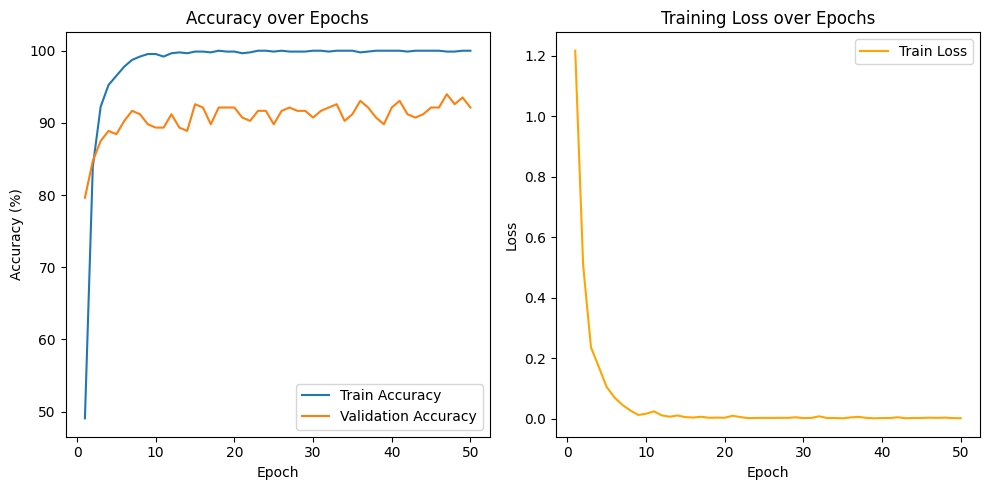

In [ ]:

model.load_state_dict(torch.load("best_vgg_50e_fix.pth"))
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")


train_losses = [
    1.2161, 0.5084, 0.2355, 0.1703, 0.1041, 0.0692, 0.0450, 0.0266, 0.0119, 0.0157,
    0.0238, 0.0104, 0.0059, 0.0100, 0.0046, 0.0033, 0.0058, 0.0025, 0.0030, 0.0026,
    0.0091, 0.0048, 0.0014, 0.0019, 0.0021, 0.0020, 0.0023, 0.0021, 0.0041, 0.0015,
    0.0020, 0.0073, 0.0018, 0.0017, 0.0006, 0.0037, 0.0055, 0.0022, 0.0008, 0.0015,
    0.0017, 0.0041, 0.0009, 0.0019, 0.0019, 0.0027, 0.0022, 0.0029, 0.0015, 0.0010
]

train_accuracies = [
    49.07, 83.91, 92.25, 95.25, 96.53, 97.80, 98.73, 99.19, 99.54, 99.54,
    99.19, 99.65, 99.77, 99.65, 99.88, 99.88, 99.77, 100.00, 99.88, 99.88,
    99.65, 99.77, 100.00, 100.00, 99.88, 100.00, 99.88, 99.88, 99.88, 100.00,
    100.00, 99.88, 100.00, 100.00, 100.00, 99.77, 99.88, 100.00, 100.00, 100.00,
    100.00, 99.88, 100.00, 100.00, 100.00, 100.00, 99.88, 99.88, 100.00, 100.00
]

val_accuracies = [
    79.63, 84.72, 87.50, 88.89, 88.43, 90.28, 91.67, 91.20, 89.81, 89.35,
    89.35, 91.20, 89.35, 88.89, 92.59, 92.13, 89.81, 92.13, 92.13, 92.13,
    90.74, 90.28, 91.67, 91.67, 89.81, 91.67, 92.13, 91.67, 91.67, 90.74,
    91.67, 92.13, 92.59, 90.28, 91.20, 93.06, 92.13, 90.74, 89.81, 92.13,
    93.06, 91.20, 90.74, 91.20, 92.13, 92.13, 93.98, 92.59, 93.52, 92.13
]


epochs_range = range(1,51)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

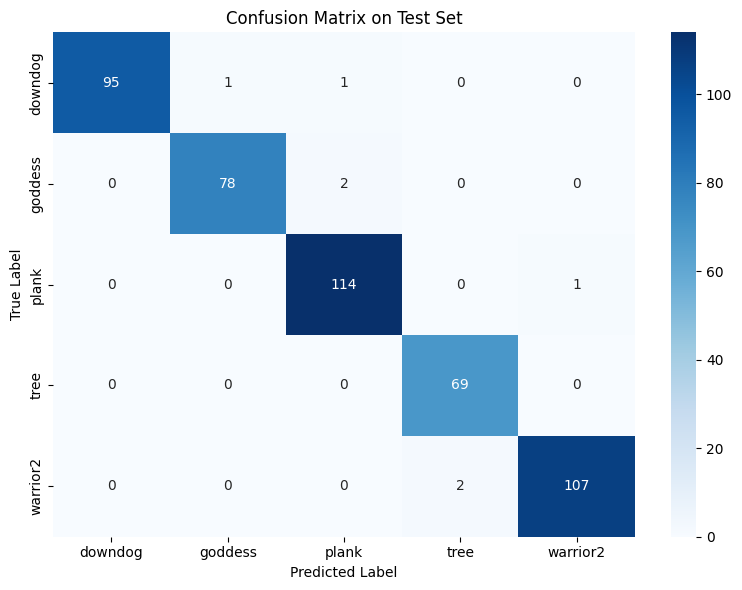


Classification Report:

              precision    recall  f1-score   support

     downdog     1.0000    0.9794    0.9896        97
     goddess     0.9873    0.9750    0.9811        80
       plank     0.9744    0.9913    0.9828       115
        tree     0.9718    1.0000    0.9857        69
    warrior2     0.9907    0.9817    0.9862       109

    accuracy                         0.9851       470
   macro avg     0.9849    0.9855    0.9851       470
weighted avg     0.9853    0.9851    0.9851       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_vgg_50e_fix.pth",
    model_name="vgg16",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)


## ========================================     


##       2. ResNet18 Model

## ========================================     


### ------------------------------------------------------------------------------------------
### 2.1 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Dataset class - same as we defined in vgg
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Build the ResNet50 model
num_classes = len(full_train_dataset.class_to_idx)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train and eval functions
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
best_val_acc = 0.0
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_yoga_50e.pth")


    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Epoch 1/50 | Train Loss: 1.6302 | Train Acc: 23.38% | Val Acc: 31.94%
Epoch 2/50 | Train Loss: 1.5583 | Train Acc: 29.86% | Val Acc: 36.11%
Epoch 3/50 | Train Loss: 1.5028 | Train Acc: 36.92% | Val Acc: 45.37%
Epoch 4/50 | Train Loss: 1.4424 | Train Acc: 41.32% | Val Acc: 50.93%
Epoch 5/50 | Train Loss: 1.4088 | Train Acc: 47.34% | Val Acc: 54.17%
Epoch 6/50 | Train Loss: 1.3591 | Train Acc: 48.38% | Val Acc: 54.63%
Epoch 7/50 | Train Loss: 1.3003 | Train Acc: 52.78% | Val Acc: 58.80%
Epoch 8/50 | Train Loss: 1.2594 | Train Acc: 56.71% | Val Acc: 61.57%
Epoch 9/50 | Train Loss: 1.2239 | Train Acc: 60.30% | Val Acc: 62.50%
Epoch 10/50 | Train Loss: 1.1928 | Train Acc: 61.81% | Val Acc: 62.04%
Epoch 11/50 | Train Loss: 1.1553 | Train Acc: 63.19% | Val Acc: 65.74%
Epoch 12/50 | Train Loss: 1.1138 | Train Acc: 66.55% | Val Acc: 68.98%
Epoch 13/50 | Train Loss: 1.0929 | Train Acc: 65.86% | Val Acc: 71.30%
Epoch 14/50 | Train Loss: 1.0567 | Train Acc: 68.75% | Val Acc: 71.30


Final Test Accuracy: 90.85%


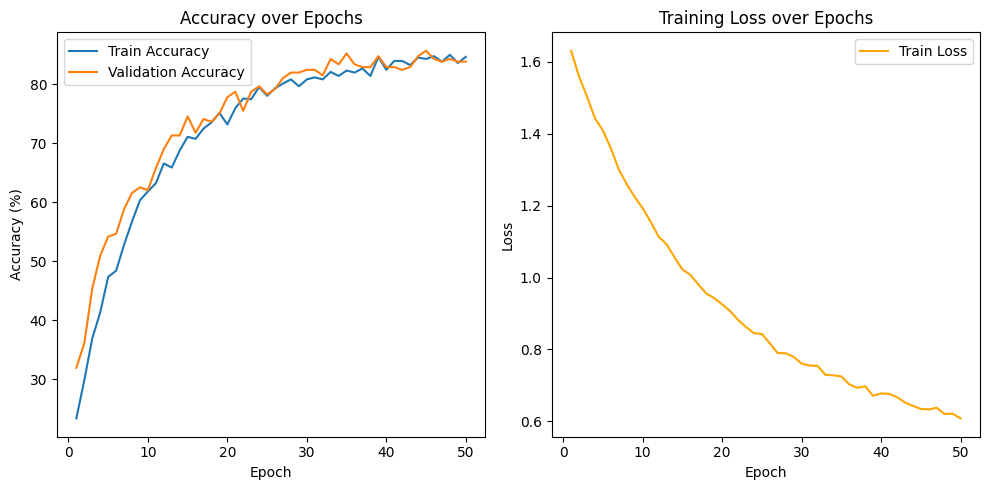

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_resnet18_yoga_50e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

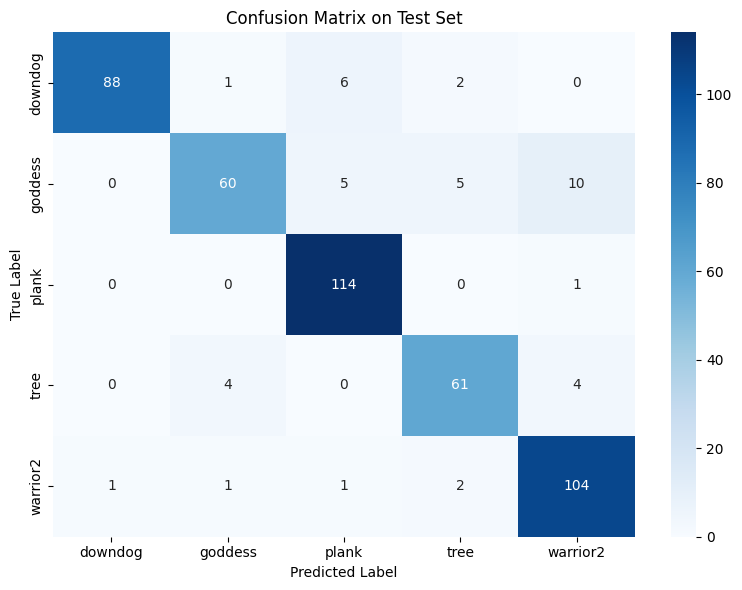


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9888    0.9072    0.9462        97
     goddess     0.9091    0.7500    0.8219        80
       plank     0.9048    0.9913    0.9461       115
        tree     0.8714    0.8841    0.8777        69
    warrior2     0.8739    0.9541    0.9123       109

    accuracy                         0.9085       470
   macro avg     0.9096    0.8973    0.9008       470
weighted avg     0.9108    0.9085    0.9071       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_resnet18_yoga_50e.pth",
    model_name="resnet18",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

### ------------------------------------------------------------------------------------------
### 2.2 - 100 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Dataset class - same as we defined in vgg
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Build the ResNet50 model
num_classes = len(full_train_dataset.class_to_idx)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train and eval functions
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 100
best_val_acc = 0.0
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_yoga_100e.pth")


    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Epoch 1/100 | Train Loss: 1.7448 | Train Acc: 19.91% | Val Acc: 24.07%
Epoch 2/100 | Train Loss: 1.5983 | Train Acc: 25.00% | Val Acc: 29.63%
Epoch 3/100 | Train Loss: 1.5397 | Train Acc: 31.37% | Val Acc: 31.48%
Epoch 4/100 | Train Loss: 1.4814 | Train Acc: 35.88% | Val Acc: 37.50%
Epoch 5/100 | Train Loss: 1.4407 | Train Acc: 40.86% | Val Acc: 39.81%
Epoch 6/100 | Train Loss: 1.3959 | Train Acc: 45.49% | Val Acc: 45.37%
Epoch 7/100 | Train Loss: 1.3478 | Train Acc: 49.19% | Val Acc: 51.39%
Epoch 8/100 | Train Loss: 1.3001 | Train Acc: 53.12% | Val Acc: 52.31%
Epoch 9/100 | Train Loss: 1.2511 | Train Acc: 56.71% | Val Acc: 57.41%
Epoch 10/100 | Train Loss: 1.2192 | Train Acc: 58.45% | Val Acc: 56.48%
Epoch 11/100 | Train Loss: 1.1876 | Train Acc: 62.50% | Val Acc: 62.50%
Epoch 12/100 | Train Loss: 1.1430 | Train Acc: 65.39% | Val Acc: 63.89%
Epoch 13/100 | Train Loss: 1.1257 | Train Acc: 65.62% | Val Acc: 62.96%
Epoch 14/100 | Train Loss: 1.1059 | Train Acc: 65.97% | 


Final Test Accuracy: 91.91%


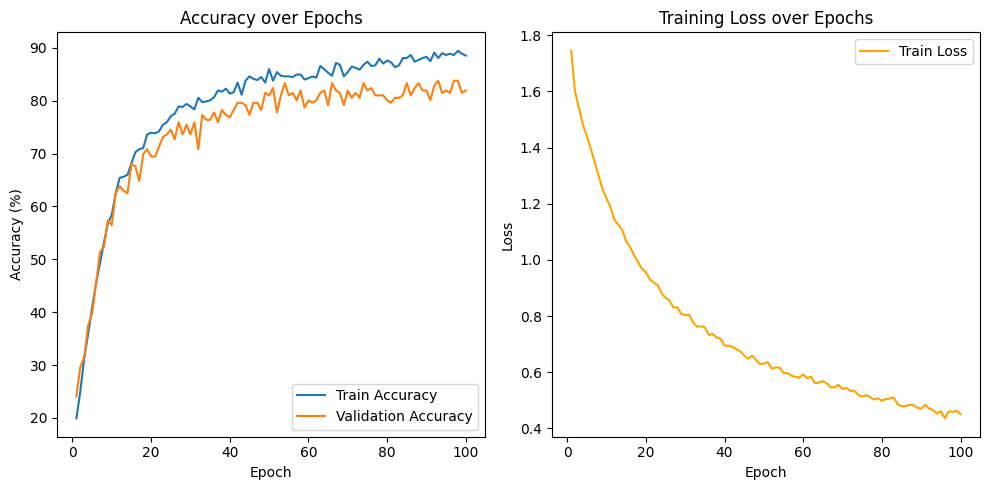

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_resnet18_yoga_100e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

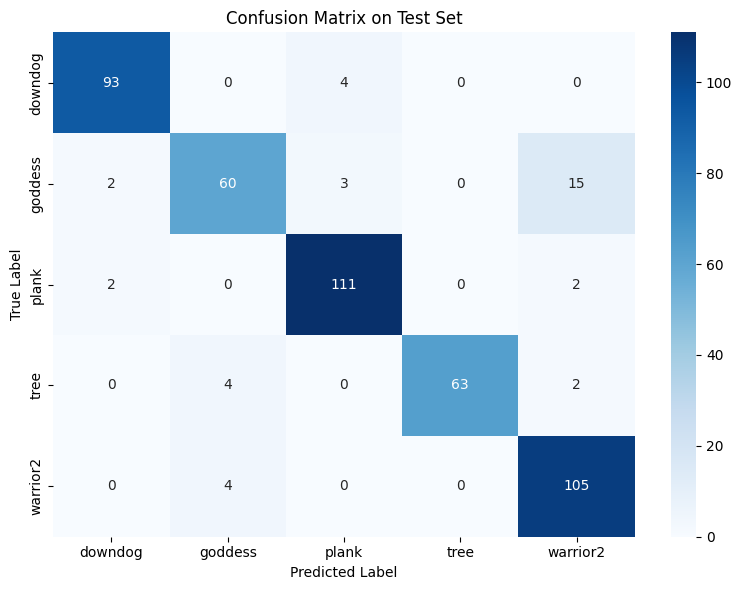


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9588    0.9588    0.9588        97
     goddess     0.8824    0.7500    0.8108        80
       plank     0.9407    0.9652    0.9528       115
        tree     1.0000    0.9130    0.9545        69
    warrior2     0.8468    0.9633    0.9013       109

    accuracy                         0.9191       470
   macro avg     0.9257    0.9101    0.9156       470
weighted avg     0.9214    0.9191    0.9182       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_resnet18_yoga_100e.pth",
    model_name="resnet18",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

### ------------------------------------------------------------------------------------------
### 2.3 - 50 Epochs - Full Training
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Custom Dataset
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Augmentations — focused on goddess-like fine-grained pose variations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # slight zoom/scale
    transforms.RandomRotation(15),                         # slight rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # for lighting conditions
    transforms.RandomHorizontalFlip(),                     # left/right
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model: ResNet18 with full fine-tuning
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_classes = len(full_train_dataset.class_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Train and Evaluate functions
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
best_val_acc = 0.0
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)

    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_yoga_50e_with_fix.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Epoch 1/50 | Train Loss: 0.8184 | Train Acc: 71.30% | Val Acc: 67.13%
Epoch 2/50 | Train Loss: 0.3955 | Train Acc: 86.81% | Val Acc: 73.61%
Epoch 3/50 | Train Loss: 0.3099 | Train Acc: 89.58% | Val Acc: 85.65%
Epoch 4/50 | Train Loss: 0.2768 | Train Acc: 88.77% | Val Acc: 77.78%
Epoch 5/50 | Train Loss: 0.1657 | Train Acc: 94.68% | Val Acc: 83.33%
Epoch 6/50 | Train Loss: 0.1908 | Train Acc: 93.52% | Val Acc: 83.33%
Epoch 7/50 | Train Loss: 0.1705 | Train Acc: 93.75% | Val Acc: 91.20%
Epoch 8/50 | Train Loss: 0.2459 | Train Acc: 92.36% | Val Acc: 89.81%
Epoch 9/50 | Train Loss: 0.1811 | Train Acc: 94.68% | Val Acc: 86.57%
Epoch 10/50 | Train Loss: 0.1151 | Train Acc: 96.30% | Val Acc: 91.20%
Epoch 11/50 | Train Loss: 0.1426 | Train Acc: 94.91% | Val Acc: 86.57%
Epoch 12/50 | Train Loss: 0.1365 | Train Acc: 95.02% | Val Acc: 88.89%
Epoch 13/50 | Train Loss: 0.0997 | Train Acc: 96.30% | Val Acc: 87.96%
Epoch 14/50 | Train Loss: 0.0720 | Train Acc: 98.03% | Val Acc: 93.06


Final Test Accuracy: 98.09%


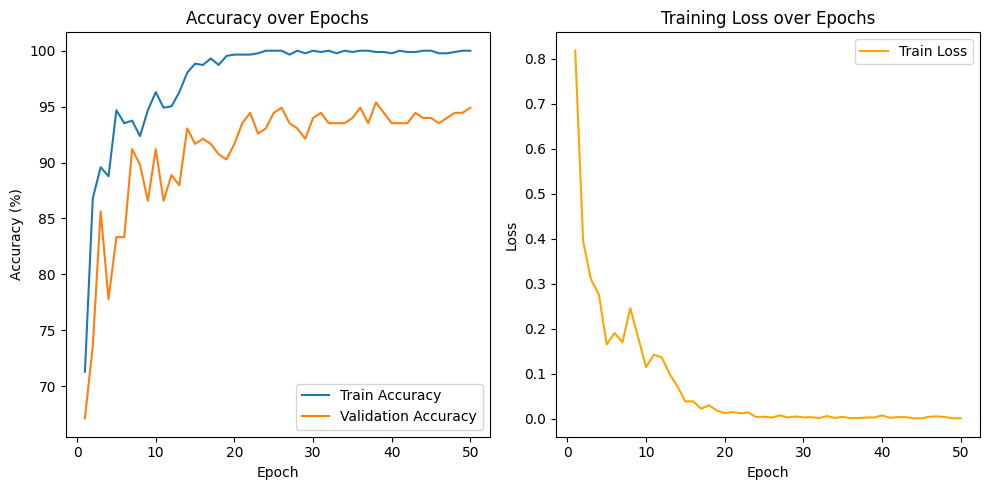

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_resnet18_yoga_50e_with_fix.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

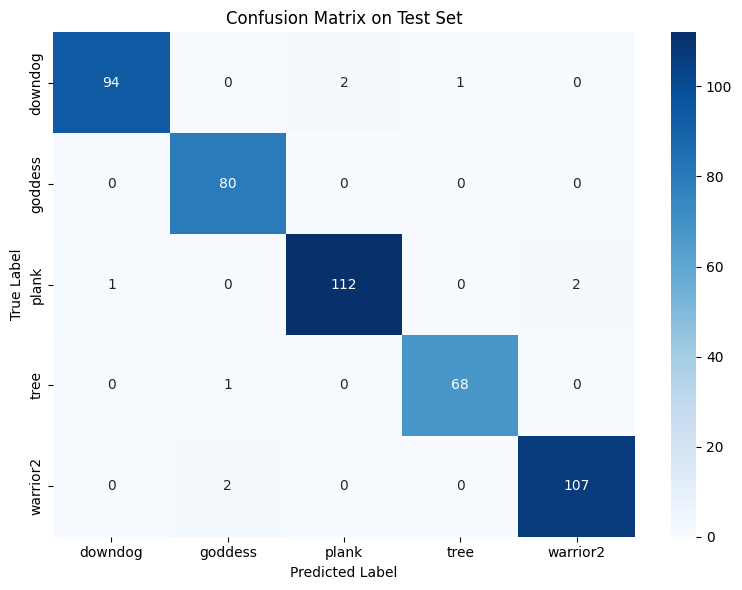


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9895    0.9691    0.9792        97
     goddess     0.9639    1.0000    0.9816        80
       plank     0.9825    0.9739    0.9782       115
        tree     0.9855    0.9855    0.9855        69
    warrior2     0.9817    0.9817    0.9817       109

    accuracy                         0.9809       470
   macro avg     0.9806    0.9820    0.9812       470
weighted avg     0.9810    0.9809    0.9808       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_resnet18_yoga_50e_with_fix.pth",
    model_name="resnet18",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

## ========================================     


##       3. GoogleNet Model

## ========================================     


### ------------------------------------------------------------------------------------------
### 3.1 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final classifier layer
num_classes = len(full_train_dataset.class_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)
for param in model.fc.parameters():
    param.requires_grad = True

# Optional: disable auxiliary classifiers to avoid multi-output complications
model.aux_logits = False

model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

def train(model, loader):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_googlenet_finetuning_50e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Epoch 1/50 | Train Loss: 1.5046 | Train Acc: 33.68% | Val Acc: 35.65%
Epoch 2/50 | Train Loss: 1.2691 | Train Acc: 51.27% | Val Acc: 64.81%
Epoch 3/50 | Train Loss: 1.1072 | Train Acc: 65.28% | Val Acc: 71.30%
Epoch 4/50 | Train Loss: 1.0168 | Train Acc: 68.63% | Val Acc: 67.13%
Epoch 5/50 | Train Loss: 0.9581 | Train Acc: 69.21% | Val Acc: 73.61%
Epoch 6/50 | Train Loss: 0.8701 | Train Acc: 73.61% | Val Acc: 73.61%
Epoch 7/50 | Train Loss: 0.8246 | Train Acc: 75.00% | Val Acc: 70.37%
Epoch 8/50 | Train Loss: 0.7936 | Train Acc: 75.69% | Val Acc: 74.07%
Epoch 9/50 | Train Loss: 0.7671 | Train Acc: 76.74% | Val Acc: 71.76%
Epoch 10/50 | Train Loss: 0.7303 | Train Acc: 76.27% | Val Acc: 74.54%
Epoch 11/50 | Train Loss: 0.7357 | Train Acc: 75.93% | Val Acc: 76.85%
Epoch 12/50 | Train Loss: 0.7109 | Train Acc: 77.20% | Val Acc: 72.69%
Epoch 13/50 | Train Loss: 0.6659 | Train Acc: 79.05% | Val Acc: 70.37%
Epoch 14/50 | Train Loss: 0.6813 | Train Acc: 77.08% | Val Acc: 75.46


Final Test Accuracy: 91.28%


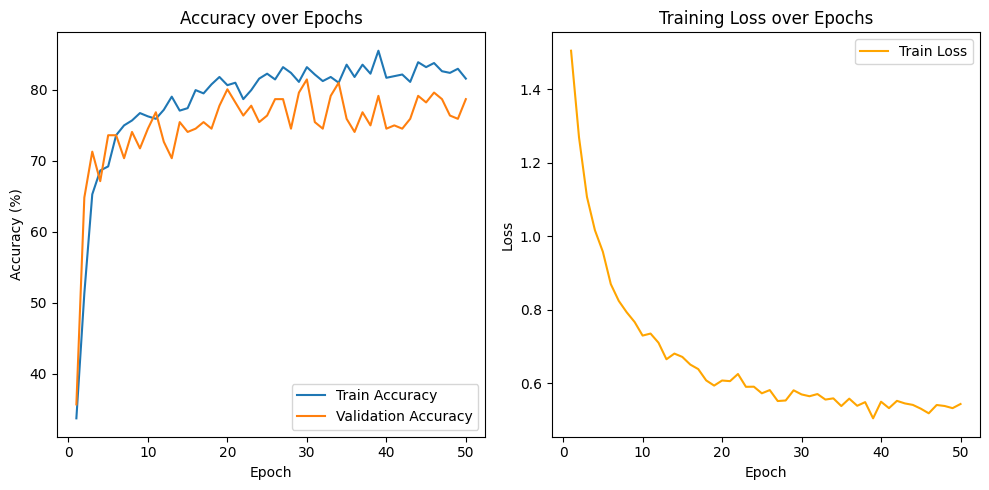

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_googlenet_finetuning_50e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### ------------------------------------------------------------------------------------------
### 3.2 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
num_classes = len(full_train_dataset.class_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

def train(model, loader):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_googlenet_50e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /home/prj7971/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:02<00:00, 19.8MB/s]
/home/prj7971/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 | Train Loss: 0.7634 | Train Acc: 72.92% | Val Acc: 74.07%
Epoch 2/50 | Train Loss: 0.3032 | Train Acc: 89.58% | Val Acc: 76.39%
Epoch 3/50 | Train Loss: 0.2240 | Train Acc: 93.40% | Val Acc: 89.81%
Epoch 4/50 | Train Loss: 0.1666 | Train Acc: 94.56% | Val Acc: 90.28%
Epoch 5/50 | Train Loss: 0.2091 | Train Acc: 93.17% | Val Acc: 81.48%
Epoch 6/50 | Train Loss: 0.2095 | Train Acc: 93.40% | Val Acc: 86.57%
Epoch 7/50 | Train Loss: 0.1466 | Train Acc: 96.18% | Val Acc: 89.35%
Epoch 8/50 | Train Loss: 0.1610 | Train Acc: 94.44% | Val Acc: 90.74%
Epoch 9/50 | Train Loss: 0.1519 | Train Acc: 94.91% | Val Acc: 88.89%
Epoch 10/50 | Train Loss: 0.1280 | Train Acc: 95.37% | Val Acc: 90.74%
Epoch 11/50 | Train Loss: 0.1080 | Train Acc: 97.11% | Val Acc: 92.13%
Epoch 12/50 | Train Loss: 0.1051 | Train Acc: 95.72% | Val Acc: 93.52%
Epoch 13/50 | Train Loss: 0.0855 | Train Acc: 97.34% | Val Acc: 90.74%
Epoch 14/50 | Train Loss: 0.0474 | Train Acc: 98.73% | Val Acc: 92.13%
Epoch 15/50 | T


Final Test Accuracy: 97.87%


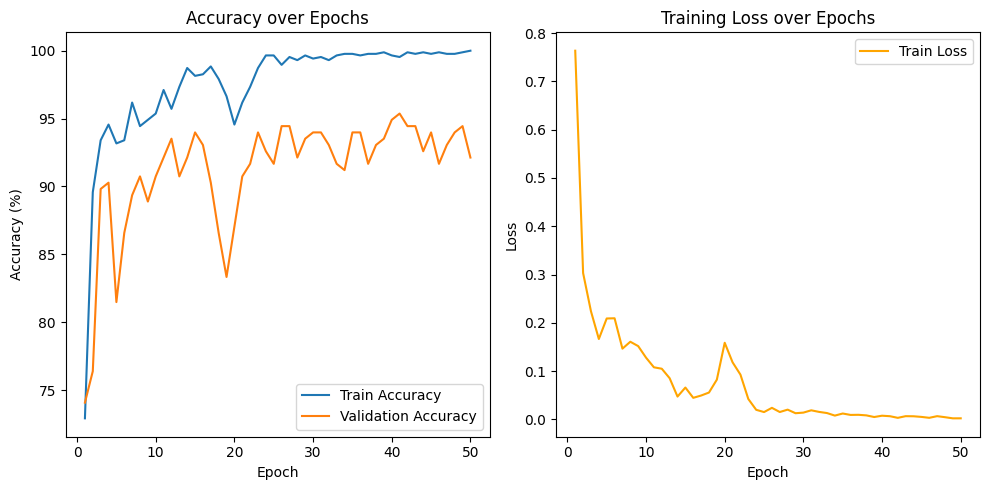

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_googlenet_50e.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

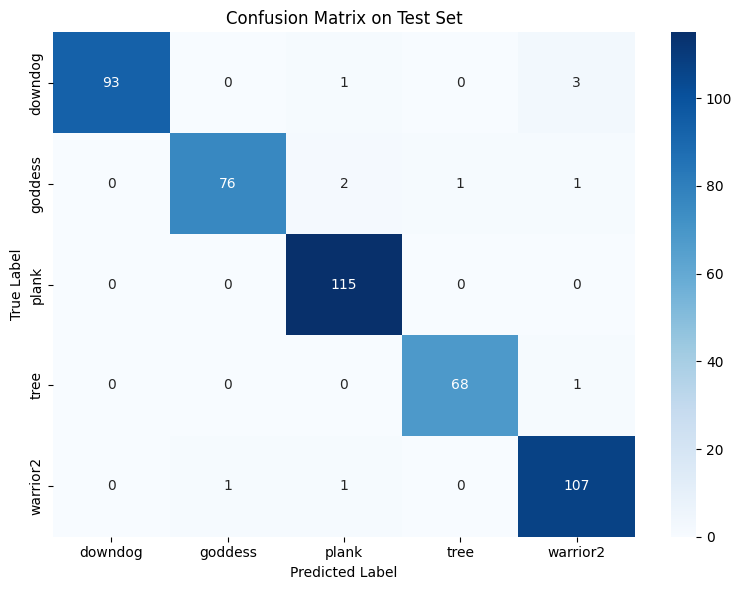


Classification Report:

              precision    recall  f1-score   support

     downdog     1.0000    0.9588    0.9789        97
     goddess     0.9870    0.9500    0.9682        80
       plank     0.9664    1.0000    0.9829       115
        tree     0.9855    0.9855    0.9855        69
    warrior2     0.9554    0.9817    0.9683       109

    accuracy                         0.9766       470
   macro avg     0.9789    0.9752    0.9768       470
weighted avg     0.9771    0.9766    0.9766       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_googlenet_50e.pth",
    model_name="googlenet",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

## ========================================     


## 4. AlexNet Model

## ========================================     


### ------------------------------------------------------------------------------------------
### 4.1 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
# Enable loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Device configuration (select GPU 1 manually)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# ---------------- Dataset Definition ---------------- #
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(cls_folder, fname)
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------- Transforms ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ---------------- Data Preparation ---------------- #
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ---------------- Model Setup ---------------- #
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
num_classes = len(full_train_dataset.class_to_idx)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final classifier layer and unfreeze it
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.classifier[6].requires_grad = True

model = model.to(device)

# ---------------- Loss, Optimizer, Scheduler ---------------- #
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# ---------------- Training & Evaluation Functions ---------------- #
def train(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return total_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# ---------------- Training Loop ---------------- #
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_alexnet_finetune_2_50e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda
Epoch 1/50 | Train Loss: 1.2168 | Train Acc: 52.43% | Val Acc: 67.59%
Epoch 2/50 | Train Loss: 0.7508 | Train Acc: 71.88% | Val Acc: 76.39%
Epoch 3/50 | Train Loss: 0.6064 | Train Acc: 78.59% | Val Acc: 75.46%
Epoch 4/50 | Train Loss: 0.5562 | Train Acc: 79.86% | Val Acc: 79.63%
Epoch 5/50 | Train Loss: 0.5353 | Train Acc: 80.32% | Val Acc: 73.15%
Epoch 6/50 | Train Loss: 0.4476 | Train Acc: 83.80% | Val Acc: 80.09%
Epoch 7/50 | Train Loss: 0.4456 | Train Acc: 83.68% | Val Acc: 81.02%
Epoch 8/50 | Train Loss: 0.4246 | Train Acc: 84.95% | Val Acc: 80.56%
Epoch 9/50 | Train Loss: 0.4109 | Train Acc: 86.00% | Val Acc: 81.02%
Epoch 10/50 | Train Loss: 0.3863 | Train Acc: 85.76% | Val Acc: 81.02%
Epoch 11/50 | Train Loss: 0.3628 | Train Acc: 87.73% | Val Acc: 79.17%
Epoch 12/50 | Train Loss: 0.3213 | Train Acc: 88.31% | Val Acc: 80.56%
Epoch 13/50 | Train Loss: 0.3452 | Train Acc: 87.04% | Val Acc: 82.41%
Epoch 14/50 | Train Loss: 0.3474 | Train Acc: 89.12% | Val Acc: 82.87


Final Test Accuracy: 90.21%


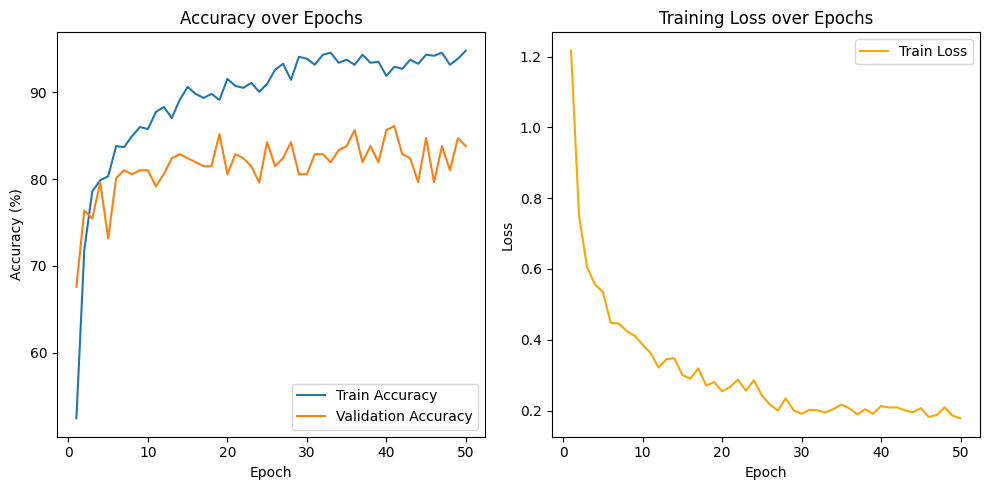

In [ ]:
# Step 1: Reconstruct the AlexNet model with fine-tuned final layer
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Replace the final classifier layer to match the number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Step 2: Load the trained weights (make sure they match the AlexNet structure)
model.load_state_dict(torch.load("best_alexnet_finetune_2_50e.pth"))

# Step 3: Move the model to GPU (or CPU)
model = model.to(device)


test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

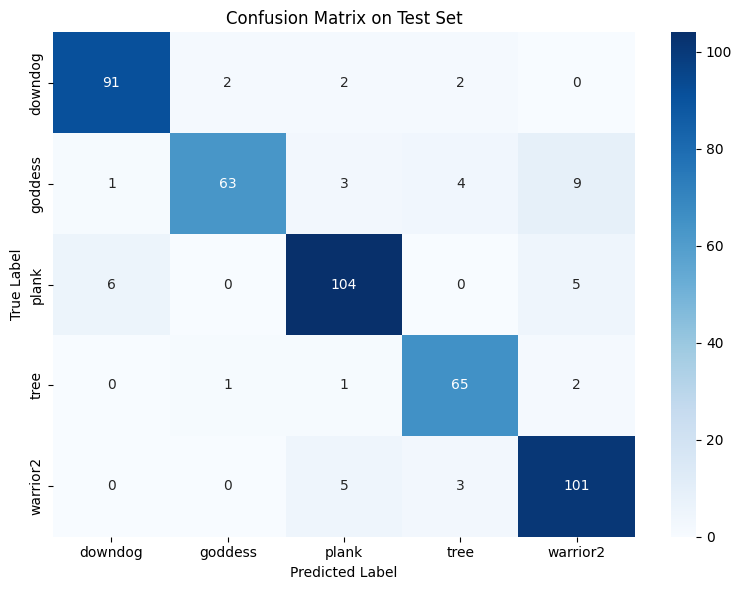


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9286    0.9381    0.9333        97
     goddess     0.9545    0.7875    0.8630        80
       plank     0.9043    0.9043    0.9043       115
        tree     0.8784    0.9420    0.9091        69
    warrior2     0.8632    0.9266    0.8938       109

    accuracy                         0.9021       470
   macro avg     0.9058    0.8997    0.9007       470
weighted avg     0.9045    0.9021    0.9015       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_alexnet_finetune_2_50e.pth",
    model_name="alexnet",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

### ------------------------------------------------------------------------------------------
### 4.2 - 50 Epochs - Full Training
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
num_classes = len(full_train_dataset.class_to_idx)

# Replace the final classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Fine-tune all layers
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Training and evaluation functions
def train(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_alexnet_fullfinetune_50e.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda:0
Epoch 1/50 | Train Loss: 1.1290 | Train Acc: 55.32% | Val Acc: 76.85%
Epoch 2/50 | Train Loss: 0.4831 | Train Acc: 80.90% | Val Acc: 85.19%
Epoch 3/50 | Train Loss: 0.3236 | Train Acc: 89.93% | Val Acc: 87.96%
Epoch 4/50 | Train Loss: 0.2535 | Train Acc: 92.59% | Val Acc: 84.72%
Epoch 5/50 | Train Loss: 0.1484 | Train Acc: 95.72% | Val Acc: 85.65%
Epoch 6/50 | Train Loss: 0.1507 | Train Acc: 94.10% | Val Acc: 87.50%
Epoch 7/50 | Train Loss: 0.1050 | Train Acc: 96.64% | Val Acc: 83.80%
Epoch 8/50 | Train Loss: 0.0894 | Train Acc: 96.64% | Val Acc: 86.57%
Epoch 9/50 | Train Loss: 0.0702 | Train Acc: 97.69% | Val Acc: 87.50%
Epoch 10/50 | Train Loss: 0.0446 | Train Acc: 98.50% | Val Acc: 86.11%
Epoch 11/50 | Train Loss: 0.0327 | Train Acc: 98.96% | Val Acc: 87.50%
Epoch 12/50 | Train Loss: 0.0270 | Train Acc: 99.42% | Val Acc: 90.28%
Epoch 13/50 | Train Loss: 0.0261 | Train Acc: 98.96% | Val Acc: 87.04%
Epoch 14/50 | Train Loss: 0.0229 | Train Acc: 99.42% | Val Acc: 87.


Final Test Accuracy: 95.74%


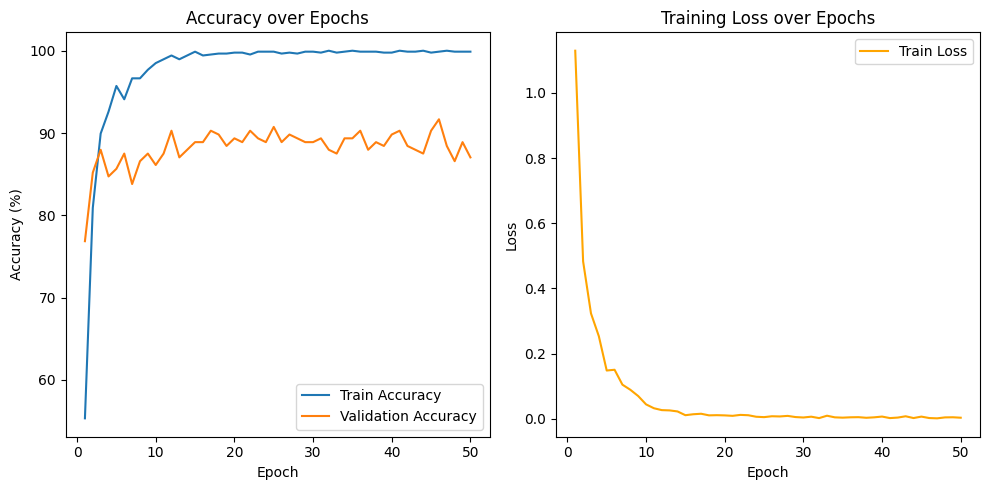

In [ ]:
# Step 1: Reconstruct the AlexNet model with fine-tuned final layer
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Replace the final classifier layer to match the number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Step 2: Load the trained weights (make sure they match the AlexNet structure)
model.load_state_dict(torch.load("best_alexnet_fullfinetune_50e.pth"))

# Step 3: Move the model to GPU (or CPU)
model = model.to(device)


test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

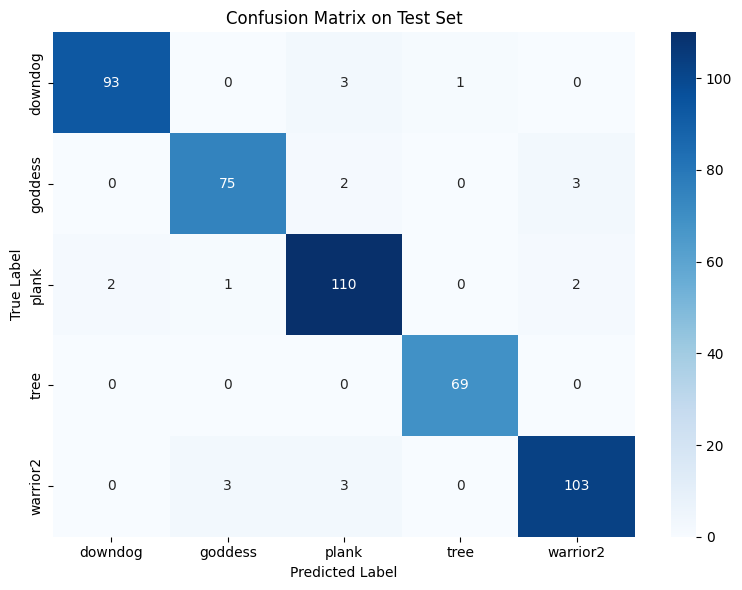


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9789    0.9588    0.9688        97
     goddess     0.9494    0.9375    0.9434        80
       plank     0.9322    0.9565    0.9442       115
        tree     0.9857    1.0000    0.9928        69
    warrior2     0.9537    0.9450    0.9493       109

    accuracy                         0.9574       470
   macro avg     0.9600    0.9595    0.9597       470
weighted avg     0.9576    0.9574    0.9575       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_alexnet_fullfinetune_50e.pth",
    model_name="alexnet",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

## ========================================     


## 5. Custom CNN

## ========================================     


### ------------------------------------------------------------------------------------------
### 5.1 - 50 Epochs - Full Training
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224x224 -> 224x224
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> 112x112
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # -> 56x56
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 28x28
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Custom dataset class
class YogaPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_folder): continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_folder, fname), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode == 'P':
            image = image.convert("RGBA").convert("RGB")
        else:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
full_train_dataset = YogaPoseDataset("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = YogaPoseDataset("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instantiate model
num_classes = len(full_train_dataset.class_to_idx)
model = SimpleCNN(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Train and eval functions
def train(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_simplecnn.pth")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")




Running on: cuda
Epoch 1/50 | Train Loss: 1.8020 | Train Acc: 23.50% | Val Acc: 16.67%
Epoch 2/50 | Train Loss: 1.5040 | Train Acc: 36.57% | Val Acc: 41.20%
Epoch 3/50 | Train Loss: 1.3732 | Train Acc: 46.41% | Val Acc: 43.06%
Epoch 4/50 | Train Loss: 1.2407 | Train Acc: 50.35% | Val Acc: 45.83%
Epoch 5/50 | Train Loss: 1.1252 | Train Acc: 57.52% | Val Acc: 52.31%
Epoch 6/50 | Train Loss: 1.0269 | Train Acc: 59.95% | Val Acc: 60.19%
Epoch 7/50 | Train Loss: 0.9456 | Train Acc: 62.85% | Val Acc: 57.87%
Epoch 8/50 | Train Loss: 0.8907 | Train Acc: 65.05% | Val Acc: 56.48%
Epoch 9/50 | Train Loss: 0.8376 | Train Acc: 67.82% | Val Acc: 62.96%
Epoch 10/50 | Train Loss: 0.7426 | Train Acc: 72.45% | Val Acc: 65.28%
Epoch 11/50 | Train Loss: 0.7016 | Train Acc: 72.34% | Val Acc: 63.43%
Epoch 12/50 | Train Loss: 0.6369 | Train Acc: 76.97% | Val Acc: 68.98%
Epoch 13/50 | Train Loss: 0.5981 | Train Acc: 77.31% | Val Acc: 65.74%
Epoch 14/50 | Train Loss: 0.5555 | Train Acc: 80.09% | Val Acc: 70.83


Final Test Accuracy: 77.66%


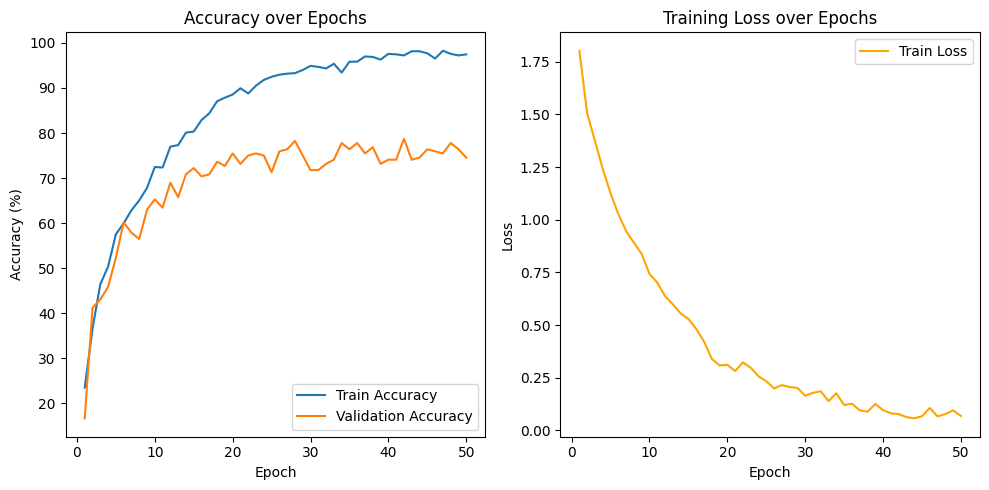

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_simplecnn.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

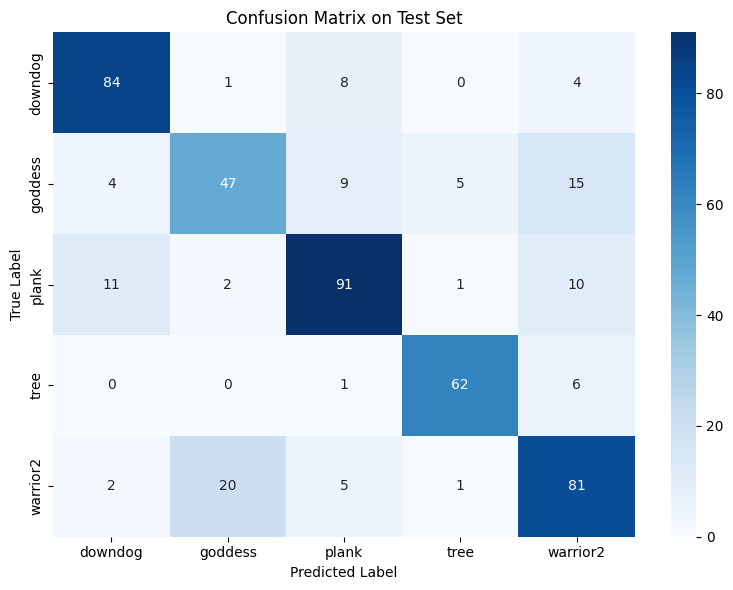


Classification Report:

              precision    recall  f1-score   support

     downdog     0.8317    0.8660    0.8485        97
     goddess     0.6714    0.5875    0.6267        80
       plank     0.7982    0.7913    0.7948       115
        tree     0.8986    0.8986    0.8986        69
    warrior2     0.6983    0.7431    0.7200       109

    accuracy                         0.7766       470
   macro avg     0.7796    0.7773    0.7777       470
weighted avg     0.7751    0.7766    0.7751       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_simplecnn.pth",
    model_name="simplecnn",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

# Models - ViT

## ========================================     


## 6. ViT Basic Model

## ========================================     


### ------------------------------------------------------------------------------------------
### 6.1 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

def handle_palette(image):
    if image.mode == 'P':
        return image.convert("RGBA").convert("RGB")
    else:
        return image.convert("RGB")

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Lambda(handle_palette),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset
full_dataset = ImageFolder("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = ImageFolder("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load ViT
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
num_classes = len(full_train_dataset.class_to_idx)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Training loop
def train(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_b16_finetune.pth")
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")




Running on: cuda:0


/home/prj7971/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 | Train Loss: 1.2673 | Train Acc: 50.69% | Val Acc: 70.97%
Epoch 2/50 | Train Loss: 0.7863 | Train Acc: 79.28% | Val Acc: 76.50%
Epoch 3/50 | Train Loss: 0.5763 | Train Acc: 85.42% | Val Acc: 79.72%
Epoch 4/50 | Train Loss: 0.4999 | Train Acc: 87.96% | Val Acc: 82.03%
Epoch 5/50 | Train Loss: 0.4132 | Train Acc: 90.86% | Val Acc: 82.95%
Epoch 6/50 | Train Loss: 0.3727 | Train Acc: 92.25% | Val Acc: 85.71%
Epoch 7/50 | Train Loss: 0.3371 | Train Acc: 92.71% | Val Acc: 86.64%
Epoch 8/50 | Train Loss: 0.3147 | Train Acc: 93.52% | Val Acc: 84.33%
Epoch 9/50 | Train Loss: 0.2806 | Train Acc: 93.63% | Val Acc: 85.71%
Epoch 10/50 | Train Loss: 0.2600 | Train Acc: 94.33% | Val Acc: 87.10%
Epoch 11/50 | Train Loss: 0.2427 | Train Acc: 95.02% | Val Acc: 86.18%
Epoch 12/50 | Train Loss: 0.2342 | Train Acc: 94.44% | Val Acc: 88.48%
Epoch 13/50 | Train Loss: 0.2092 | Train Acc: 95.49% | Val Acc: 86.64%
Epoch 14/50 | Train Loss: 0.1991 | Train Acc: 95.83% | Val Acc: 87.56%
Epoch 15/50 | T


Final Test Accuracy: 95.74%


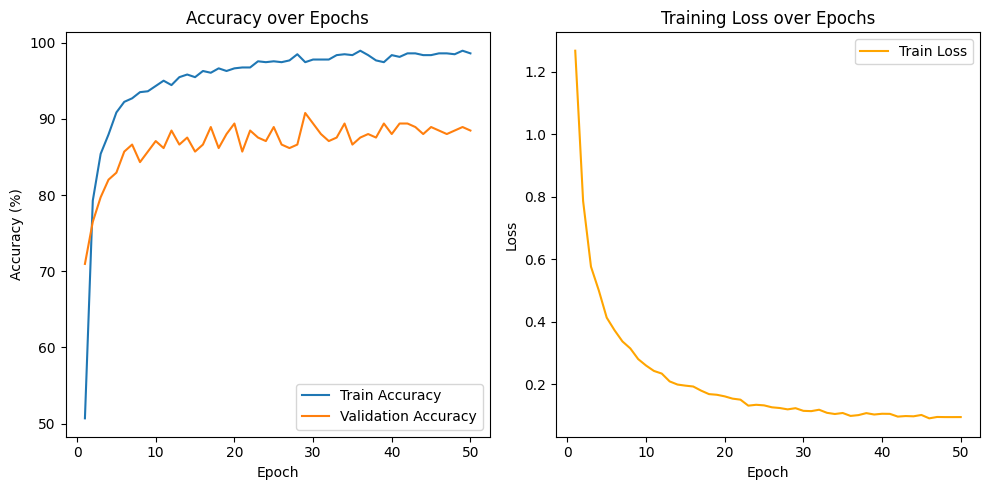

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_vit_b16_finetune.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

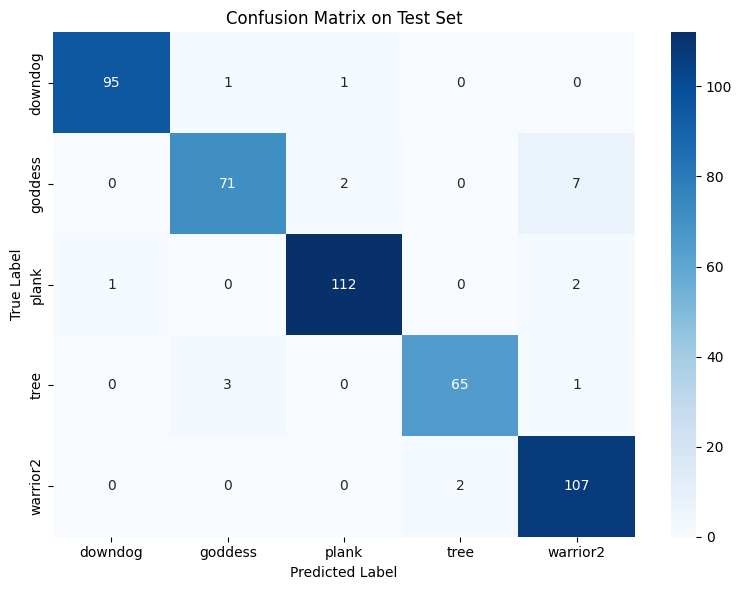


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9896    0.9794    0.9845        97
     goddess     0.9467    0.8875    0.9161        80
       plank     0.9739    0.9739    0.9739       115
        tree     0.9701    0.9420    0.9559        69
    warrior2     0.9145    0.9817    0.9469       109

    accuracy                         0.9574       470
   macro avg     0.9590    0.9529    0.9555       470
weighted avg     0.9582    0.9574    0.9573       470



In [ ]:
confusion_matrix_and_stats(
    model_path="best_vit_b16_finetune.pth",
    model_name="vit",
    num_classes=5,
    test_loader=test_loader,
    device=device,
    class_names=list(full_train_dataset.class_to_idx.keys())
)

## ========================================     


## 7. DINOv2 Model

## ========================================     


### ------------------------------------------------------------------------------------------
### 7.1 - 50 Epochs - Fine-tuning a pre-trained model
### ------------------------------------------------------------------------------------------

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Handle palette images
def handle_palette(image):
    if image.mode == 'P' or 'transparency' in image.info:
        return image.convert("RGBA").convert("RGB")
    else:
        return image.convert("RGB")

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(518, scale=(0.85, 1.0)),  # DINOv2 input size
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Lambda(handle_palette),
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset
full_dataset = ImageFolder("yoga_aayush/DATASET/TRAIN", transform=transform_train)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = ImageFolder("yoga_aayush/DATASET/TEST", transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load DINOv2 ViT-B/14 model
model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classification head properly
num_classes = len(full_dataset.class_to_idx)
model.head = nn.Linear(model.num_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Training loop
def train(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

# Training loop
epochs = 50
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_dinov2_vit_b14.pth")
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Running on: cuda:0


/home/prj7971/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 | Train Loss: 0.9455 | Train Acc: 63.77% | Val Acc: 77.88%
Epoch 2/50 | Train Loss: 0.3899 | Train Acc: 89.24% | Val Acc: 88.48%
Epoch 3/50 | Train Loss: 0.2683 | Train Acc: 93.06% | Val Acc: 87.10%
Epoch 4/50 | Train Loss: 0.2109 | Train Acc: 94.68% | Val Acc: 92.17%
Epoch 5/50 | Train Loss: 0.1816 | Train Acc: 95.95% | Val Acc: 91.24%
Epoch 6/50 | Train Loss: 0.1573 | Train Acc: 96.18% | Val Acc: 91.24%
Epoch 7/50 | Train Loss: 0.1320 | Train Acc: 97.22% | Val Acc: 93.55%
Epoch 8/50 | Train Loss: 0.1294 | Train Acc: 97.11% | Val Acc: 92.17%
Epoch 9/50 | Train Loss: 0.1096 | Train Acc: 97.80% | Val Acc: 91.24%
Epoch 10/50 | Train Loss: 0.1008 | Train Acc: 97.92% | Val Acc: 92.63%
Epoch 11/50 | Train Loss: 0.0942 | Train Acc: 98.03% | Val Acc: 91.71%
Epoch 12/50 | Train Loss: 0.0827 | Train Acc: 98.38% | Val Acc: 93.09%
Epoch 13/50 | Train Loss: 0.0881 | Train Acc: 97.92% | Val Acc: 92.17%
Epoch 14/50 | Train Loss: 0.0754 | Train Acc: 98.50% | Val Acc: 91.71%
Epoch 15/50 | T


Final Test Accuracy: 97.87%


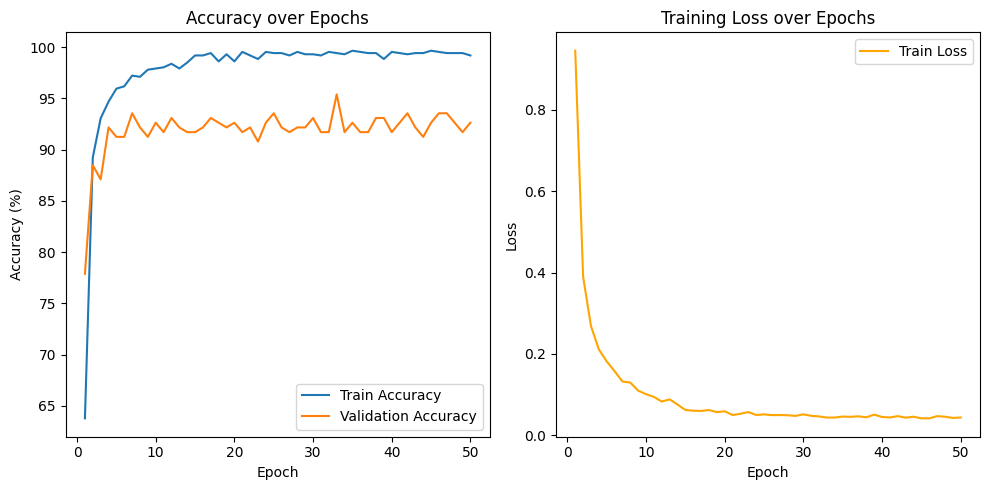

In [ ]:
# Load best model and test
model.load_state_dict(torch.load("best_dinov2_vit_b14.pth"))
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Plot graphs
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

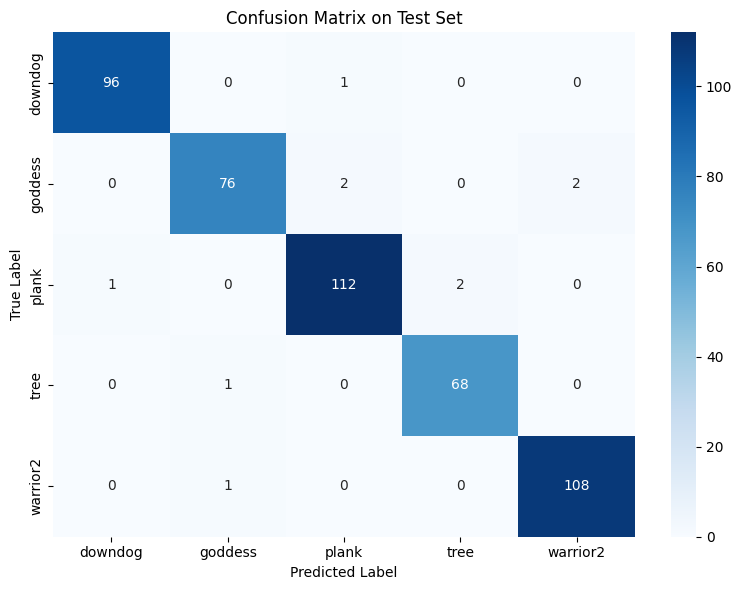


Classification Report:

              precision    recall  f1-score   support

     downdog     0.9897    0.9897    0.9897        97
     goddess     0.9744    0.9500    0.9620        80
       plank     0.9739    0.9739    0.9739       115
        tree     0.9714    0.9855    0.9784        69
    warrior2     0.9818    0.9908    0.9863       109

    accuracy                         0.9787       470
   macro avg     0.9782    0.9780    0.9781       470
weighted avg     0.9787    0.9787    0.9787       470



In [ ]:
model.eval()

all_preds = []
all_labels = []
class_names=list(full_train_dataset.class_to_idx.keys())
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0)
print("\nClassification Report:\n")
print(report)


## ========================================     


## 8. PoseGNN

## ========================================     


### ------------------------------------------------------------------------------------------
### 8.1 - 50 Epochs - Full Training
### ------------------------------------------------------------------------------------------

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def extract_keypoints(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb)
    if not result.pose_landmarks:
        return None
    return [(lm.x, lm.y) for lm in result.pose_landmarks.landmark]

def process_dataset(data_root, output_json):
    samples = []

def process_dataset(data_root, output_json):
    samples = []
    ALLOWED_CLASSES = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

    # Include only allowed folders
    class_names = sorted([
        d for d in os.listdir(data_root)
        if d in ALLOWED_CLASSES and os.path.isdir(os.path.join(data_root, d))
    ])
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    print("Class-to-index mapping:", class_to_idx)

    for cls in class_names:
        cls_path = os.path.join(data_root, cls)
        for fname in tqdm(os.listdir(cls_path), desc=cls):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            fpath = os.path.join(cls_path, fname)
            keypoints = extract_keypoints(fpath)
            if keypoints:
                samples.append({
                    "path": fpath,
                    "label": class_to_idx[cls],
                    "keypoints": keypoints
                })

    with open(output_json, 'w') as f:
        json.dump(samples, f)


# Run once to generate JSONs
process_dataset("yoga_aayush/DATASET/TRAIN", "train_keypoints.json")
process_dataset("yoga_aayush/DATASET/TEST", "test_keypoints.json")


I0000 00:00:1751019729.280384  266412 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751019729.322269  271433 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA RTX A5000/PCIe/SSE2


Class-to-index mapping: {'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}


downdog:   0%|          | 0/223 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751019729.421254  271419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751019729.495857  271427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751019729.529899  271420 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
warrior2: 100%|██████████| 252/252 [00:18<00:00, 13.56it/s]


Class-to-index mapping: {'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}


warrior2: 100%|██████████| 109/109 [00:08<00:00, 13.28it/s]


In [ ]:


# Define skeleton edges between 33 keypoints
POSE_EDGES = [(0, 1), (1, 2), (2, 3), (3, 7),
              (0, 4), (4, 5), (5, 6), (6, 8),
              (9, 10), (11, 12), (11, 13), (13, 15),
              (12, 14), (14, 16), (11, 23), (12, 24),
              (23, 24), (23, 25), (24, 26), (25, 27),
              (26, 28), (27, 29), (28, 30), (29, 31),
              (30, 32)]

edge_index = torch.tensor(POSE_EDGES, dtype=torch.long).t().contiguous()

def augment_keypoints(keypoints):
    keypoints = torch.tensor(keypoints, dtype=torch.float32)

    # Normalize before augmentation
    min_vals = keypoints.min(dim=0, keepdim=True).values
    max_vals = keypoints.max(dim=0, keepdim=True).values
    keypoints = (keypoints - min_vals) / (max_vals - min_vals + 1e-6)

    # Random rotation
    if random.random() < 0.5:
        angle = random.uniform(-25, 25) * math.pi / 180
        center = keypoints.mean(dim=0, keepdim=True)
        rot_matrix = torch.tensor([[math.cos(angle), -math.sin(angle)],
                                   [math.sin(angle),  math.cos(angle)]])
        keypoints = (keypoints - center) @ rot_matrix.T + center

    # Random scale
    if random.random() < 0.5:
        scale = random.uniform(0.9, 1.1)
        keypoints = (keypoints - 0.5) * scale + 0.5

    # Random horizontal flip
    if random.random() < 0.5:
        keypoints[:, 0] = 1.0 - keypoints[:, 0]

    # Random translation
    if random.random() < 0.5:
        shift = torch.empty(1, 2).uniform_(-0.05, 0.05)
        keypoints += shift

    # Add small Gaussian noise
    if random.random() < 0.5:
        noise = torch.randn_like(keypoints) * 0.01
        keypoints += noise

    # Randomly zero a few keypoints (simulate occlusion)
    if random.random() < 0.3:
        drop_indices = random.sample(range(keypoints.size(0)), k=random.randint(1, 3))
        for idx in drop_indices:
            keypoints[idx] = 0

    keypoints.clamp_(0.0, 1.0)
    return keypoints

class PoseGraphDataset(Dataset):
    def __init__(self, json_path, train=True):
        super().__init__()
        self.train = train
        with open(json_path, 'r') as f:
            self.samples = json.load(f)

        for i, sample in enumerate(self.samples):
            if len(sample['keypoints']) != 33:
                print(f"Sample {i} has {len(sample['keypoints'])} keypoints (expected 33)")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        keypoints = sample['keypoints']

        if self.train:
            keypoints = augment_keypoints(keypoints)
        else:
            keypoints = torch.tensor(keypoints, dtype=torch.float32)
            min_vals = keypoints.min(dim=0, keepdim=True).values
            max_vals = keypoints.max(dim=0, keepdim=True).values
            keypoints = (keypoints - min_vals) / (max_vals - min_vals + 1e-6)

        label = torch.tensor(sample['label'], dtype=torch.long)
        return Data(x=keypoints, edge_index=edge_index, y=label)


In [ ]:
class PoseGNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, dropout_rate=0.3):
        super(PoseGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)

        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)

        self.lin = nn.Linear(hidden_dim, 5)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = global_mean_pool(x, batch)
        return self.lin(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = PoseGraphDataset("train_keypoints.json")
test_dataset = PoseGraphDataset("test_keypoints.json")

# Split validation set from train
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model = PoseGNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

def train():
    model.train()
    total_loss, correct = 0, 0
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(data.y).sum().item()
    return total_loss / len(train_loader), correct / len(train_dataset)

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            correct += out.argmax(dim=1).eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 51):
    train_loss, train_acc = train()
    val_acc = evaluate(val_loader)
    scheduler.step(val_acc)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc * 100)
    val_accuracies.append(val_acc * 100)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch {epoch:02d}/50 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

# Save best model
torch.save(best_model_state, "best_poseGNN_50e.pth")


/home/prj7971/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/50 | Train Loss: 1.3264 | Train Acc: 52.22% | Val Acc: 36.06%
Epoch 02/50 | Train Loss: 1.0228 | Train Acc: 61.46% | Val Acc: 51.44%
Epoch 03/50 | Train Loss: 0.9659 | Train Acc: 64.35% | Val Acc: 65.87%
Epoch 04/50 | Train Loss: 0.9128 | Train Acc: 63.27% | Val Acc: 67.79%
Epoch 05/50 | Train Loss: 0.9121 | Train Acc: 66.27% | Val Acc: 64.90%
Epoch 06/50 | Train Loss: 0.8665 | Train Acc: 67.11% | Val Acc: 69.71%
Epoch 07/50 | Train Loss: 0.8447 | Train Acc: 68.43% | Val Acc: 72.12%
Epoch 08/50 | Train Loss: 0.8157 | Train Acc: 67.83% | Val Acc: 75.00%
Epoch 09/50 | Train Loss: 0.7895 | Train Acc: 69.87% | Val Acc: 75.00%
Epoch 10/50 | Train Loss: 0.8056 | Train Acc: 68.43% | Val Acc: 66.35%
Epoch 11/50 | Train Loss: 0.7570 | Train Acc: 72.27% | Val Acc: 80.29%
Epoch 12/50 | Train Loss: 0.7870 | Train Acc: 74.07% | Val Acc: 73.56%
Epoch 13/50 | Train Loss: 0.7596 | Train Acc: 71.31% | Val Acc: 71.15%
Epoch 14/50 | Train Loss: 0.7896 | Train Acc: 73.35% | Val Acc: 73.56%
Epoch 


Final Test Accuracy: 88.39%


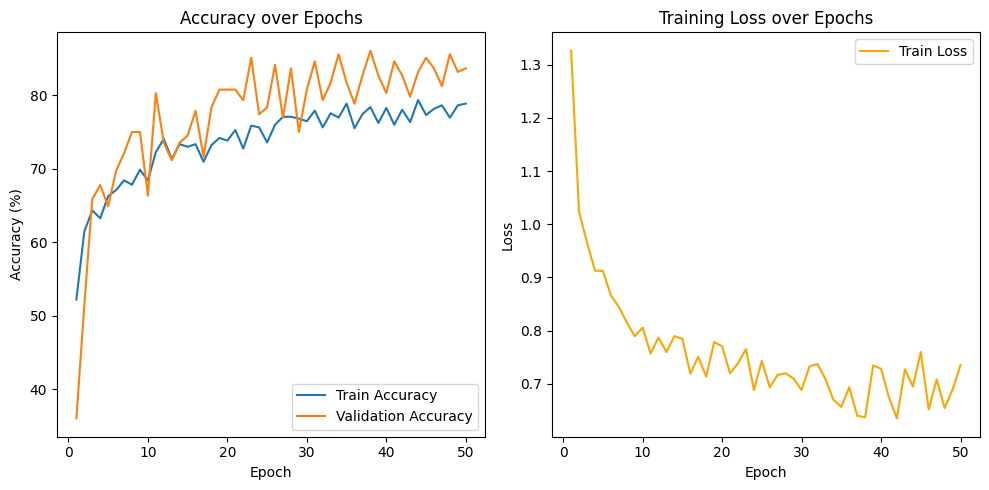

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_poseGNN_50e.pth"))
test_acc = evaluate(test_loader)
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")

# Plot results
epochs_range = range(1, 51)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### ------------------------------------------------------------------------------------------
### 8.2 - 50 Epochs - Full Training - Method 2
### ------------------------------------------------------------------------------------------

In [ ]:
def label_smoothing_loss(output, target, smoothing=0.1):
    confidence = 1.0 - smoothing
    log_probs = F.log_softmax(output, dim=-1)
    n_classes = output.size(1)
    true_dist = torch.zeros_like(output)
    true_dist.fill_(smoothing / (n_classes - 1))
    true_dist.scatter_(1, target.unsqueeze(1), confidence)
    return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))


In [ ]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.loader import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = PoseGraphDataset("train_keypoints.json")
test_dataset = PoseGraphDataset("test_keypoints.json")

# Split validation set from train
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model = PoseGNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

def train():
    model.train()
    total_loss, correct = 0, 0
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        loss = label_smoothing_loss(out, data.y, smoothing=0.05)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(data.y).sum().item()
    return total_loss / len(train_loader), correct / len(train_dataset)

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            correct += out.argmax(dim=1).eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 51):
    train_loss, train_acc = train()
    val_acc = evaluate(val_loader)
    scheduler.step(val_acc)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc * 100)
    val_accuracies.append(val_acc * 100)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch {epoch:02d}/50 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

# Save best model
torch.save(best_model_state, "best_poseGNN_50e_sec.pth")


Epoch 01/50 | Train Loss: 1.3342 | Train Acc: 49.58% | Val Acc: 17.31%
Epoch 02/50 | Train Loss: 1.0983 | Train Acc: 61.82% | Val Acc: 41.83%
Epoch 03/50 | Train Loss: 1.0497 | Train Acc: 64.95% | Val Acc: 60.10%
Epoch 04/50 | Train Loss: 0.9963 | Train Acc: 66.39% | Val Acc: 62.50%
Epoch 05/50 | Train Loss: 0.9679 | Train Acc: 63.99% | Val Acc: 63.46%
Epoch 06/50 | Train Loss: 0.9617 | Train Acc: 67.83% | Val Acc: 66.35%
Epoch 07/50 | Train Loss: 0.9394 | Train Acc: 69.75% | Val Acc: 68.27%
Epoch 08/50 | Train Loss: 0.9380 | Train Acc: 68.55% | Val Acc: 67.79%
Epoch 09/50 | Train Loss: 0.9438 | Train Acc: 72.27% | Val Acc: 65.87%
Epoch 10/50 | Train Loss: 0.9254 | Train Acc: 72.27% | Val Acc: 69.71%
Epoch 11/50 | Train Loss: 0.9317 | Train Acc: 72.15% | Val Acc: 69.23%
Epoch 12/50 | Train Loss: 0.8931 | Train Acc: 71.91% | Val Acc: 72.12%
Epoch 13/50 | Train Loss: 0.8775 | Train Acc: 74.55% | Val Acc: 67.79%
Epoch 14/50 | Train Loss: 0.8575 | Train Acc: 73.83% | Val Acc: 75.96%
Epoch 


Final Test Accuracy: 89.03%


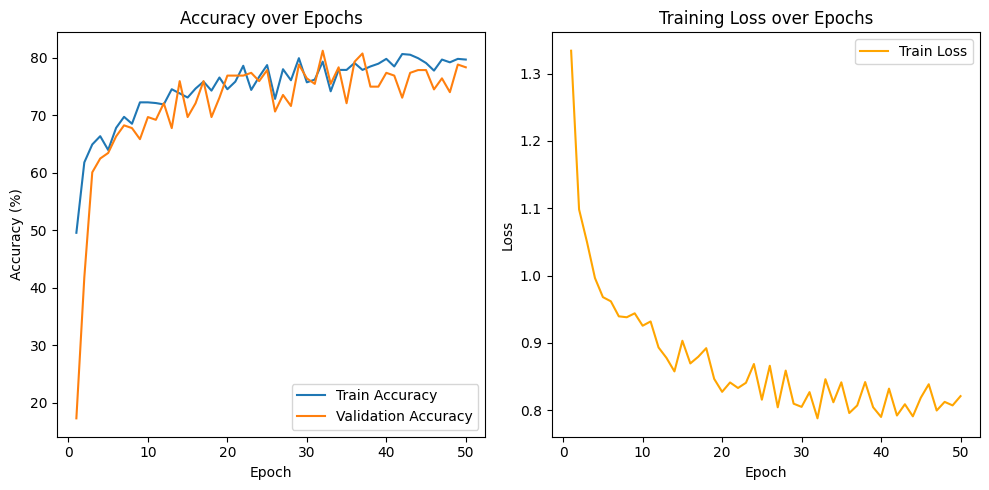

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_poseGNN_50e_sec.pth"))
test_acc = evaluate(test_loader)
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")

# Plot results
epochs_range = range(1, 51)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Explainability

### VGG16


 Final Test Accuracy: 98.51%


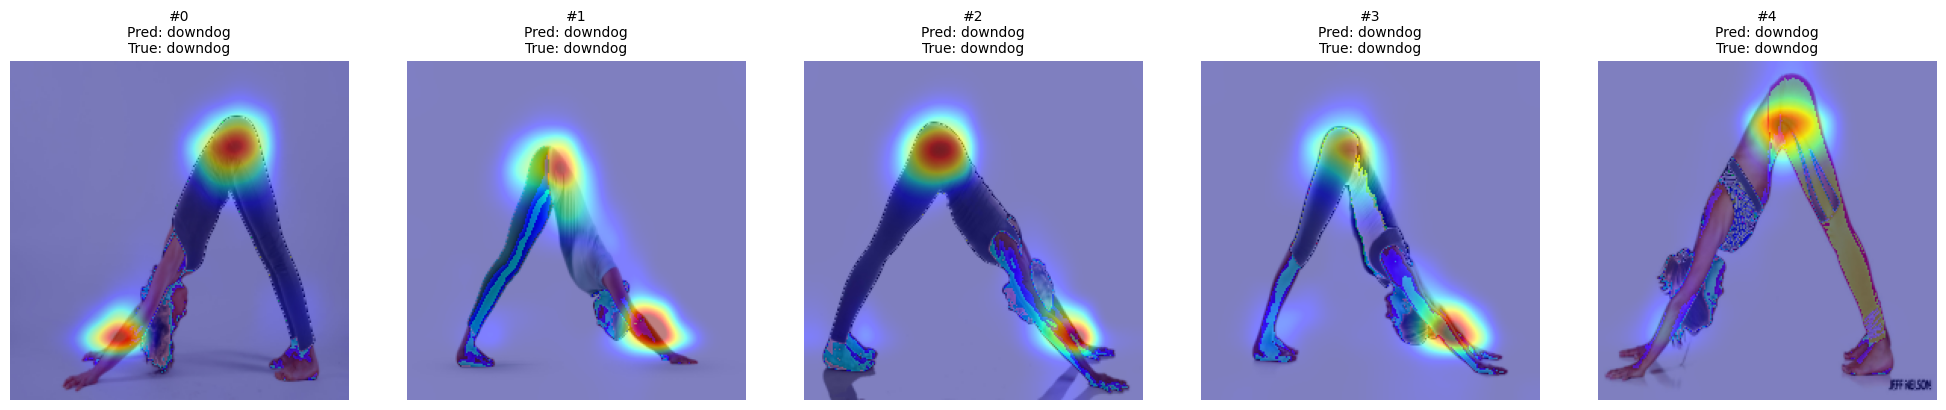

In [ ]:
model = load_model("vgg16", num_classes=5, model_path="best_vgg_50e_fix.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
show_gradcam_row_general(model,arch="vgg",n=5,start=0,method="gradcam")


 Final Test Accuracy: 95.11%


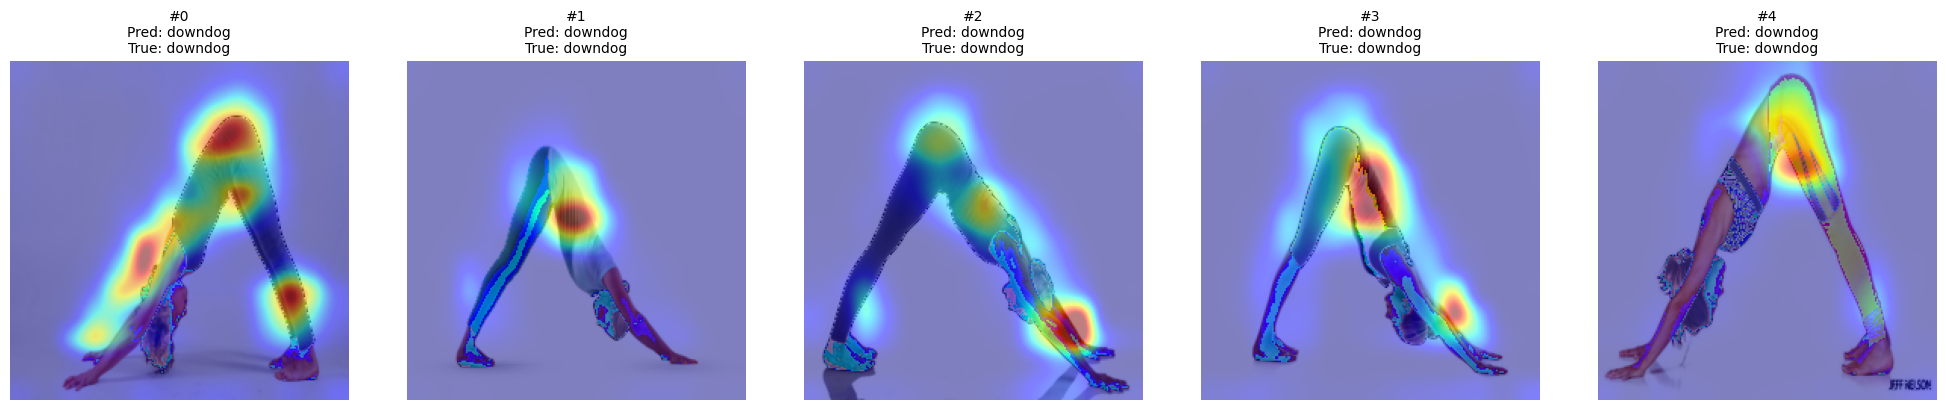

In [ ]:
model = load_model("vgg16", num_classes=5, model_path="best_vgg_yoga_50e_headonly.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
show_gradcam_row_general(model,arch="vgg",n=5,start=0,method="gradcampp")

### Resnet18


 Final Test Accuracy: 98.09%


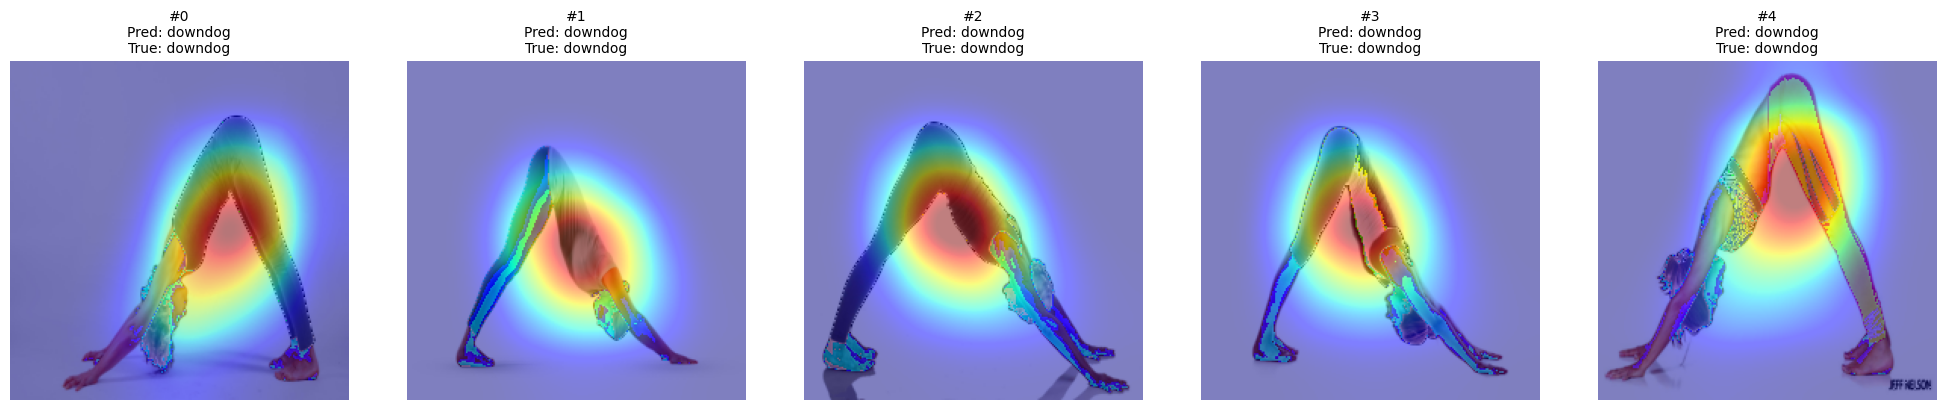

In [ ]:
model = load_model("resnet18", num_classes=5, model_path="best_resnet18_yoga_50e_with_fix.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
show_gradcam_row_general(model,arch="resnet",n=5,start=0,method="gradcam")

### Googlenet


 Final Test Accuracy: 97.66%


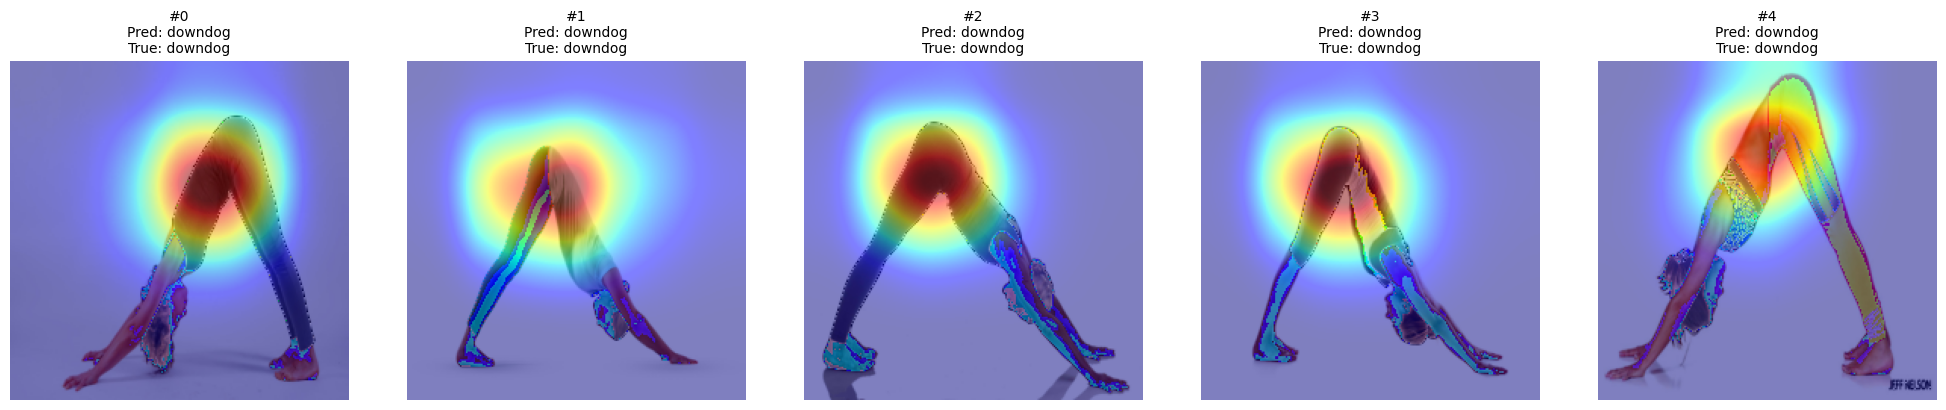

In [ ]:
model = load_model("googlenet", num_classes=5, model_path="best_googlenet_50e.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
print(f"\n Accuracy test set : {acc:.2f}%")
show_gradcam_row_general(model,arch="googlenet",n=5,start=0,method="gradcam")

### Alexnet


 Final Test Accuracy: 95.74%


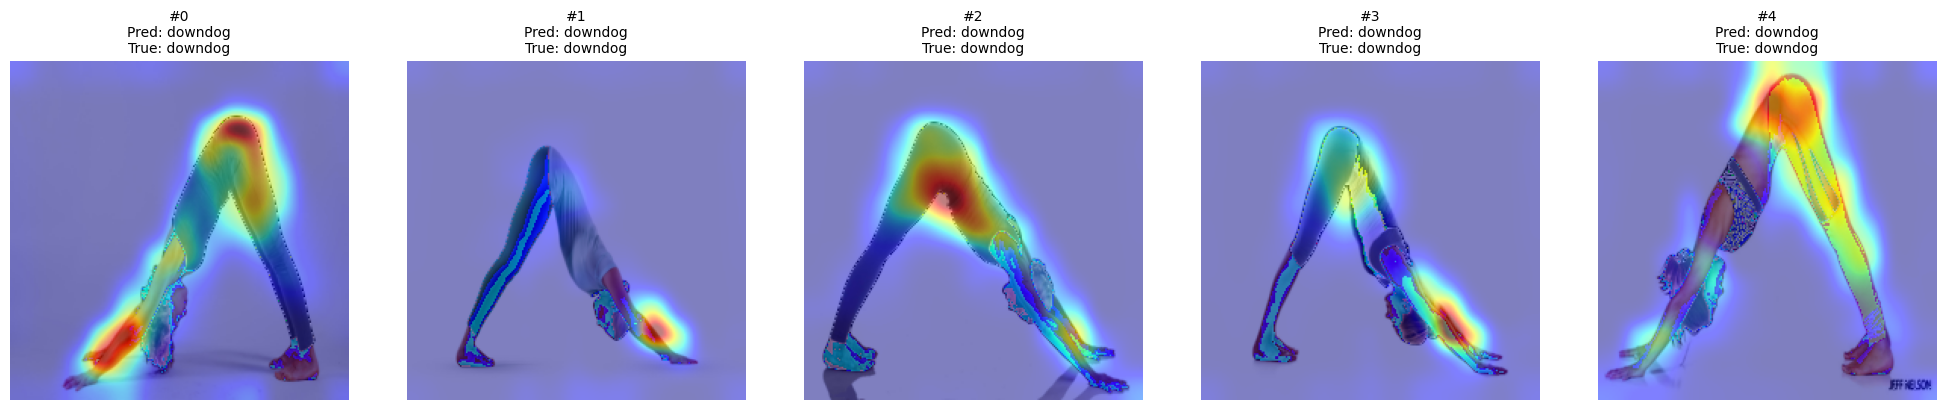

In [ ]:
model = load_model("alexnet", num_classes=5, model_path="best_alexnet_fullfinetune_50e.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
show_gradcam_row_general(model,arch="alexnet",n=5,start=0,method="gradcam")


 Final Test Accuracy: 90.21%


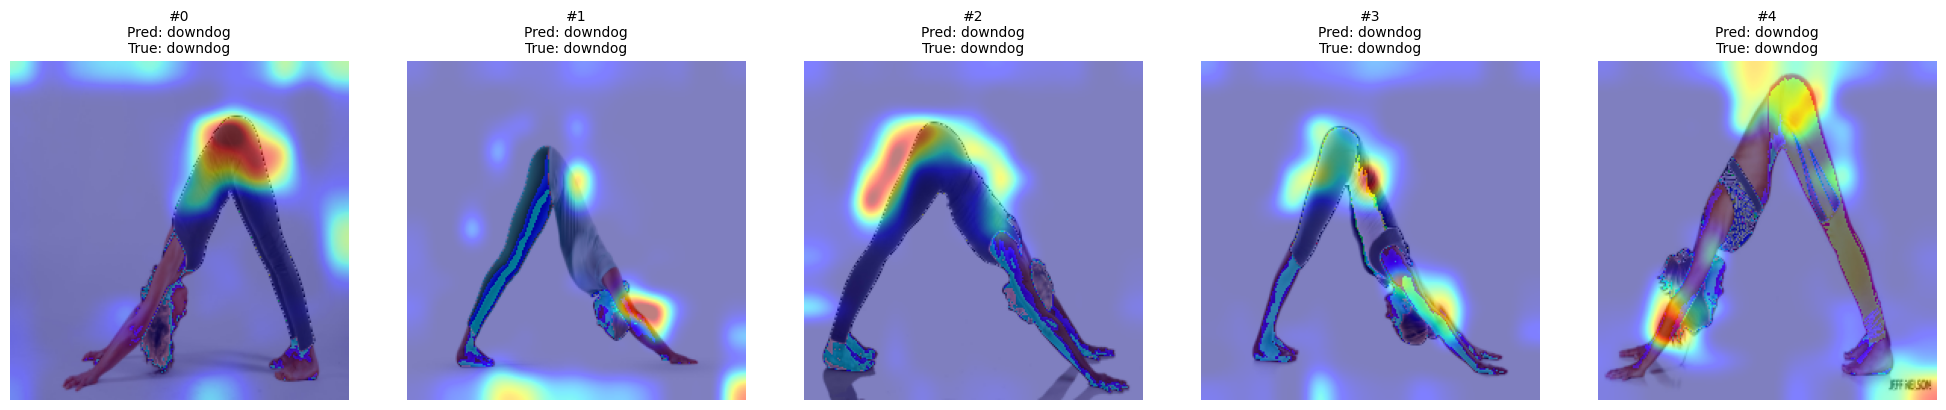

In [ ]:
model = load_model("alexnet", num_classes=5, model_path="best_alexnet_finetune_2_50e.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
show_gradcam_row_general(model,arch="alexnet",n=5,start=0,method="gradcam")

### Custom CNN


 Final Test Accuracy: 77.66%


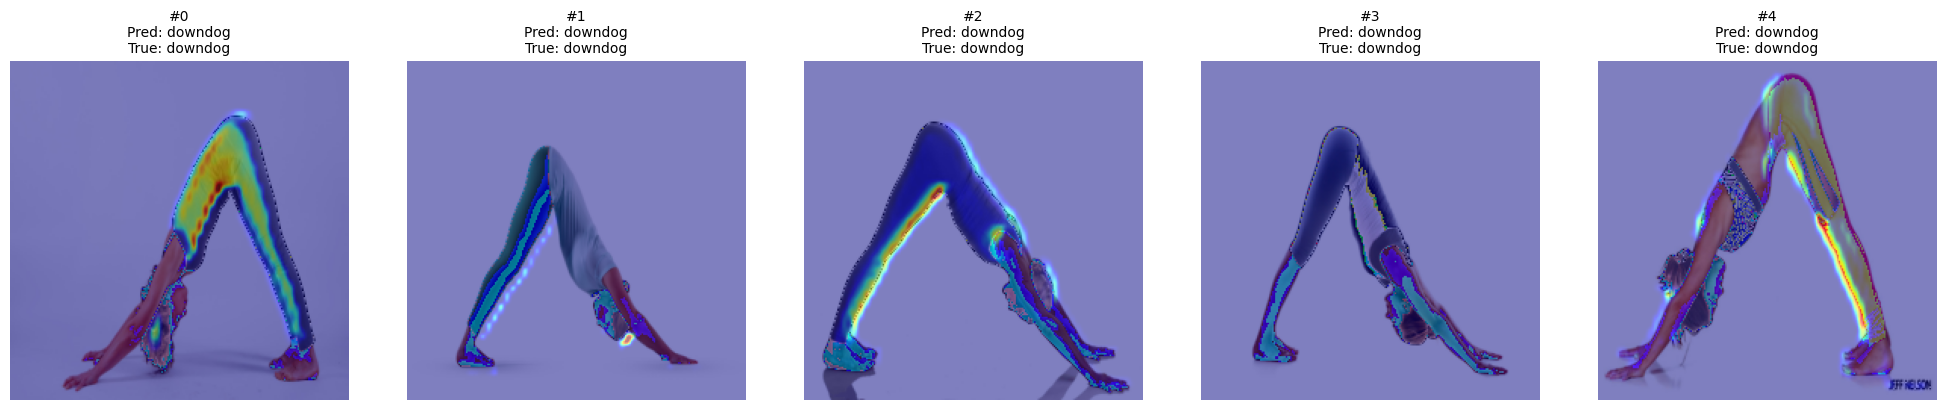

In [ ]:
model = load_model("simplecnn", num_classes=5, model_path="best_simplecnn.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
show_gradcam_row_general(model,arch="custom",n=5,start=0,method="gradcam")

### Basic ViT


 Final Test Accuracy: 95.74%


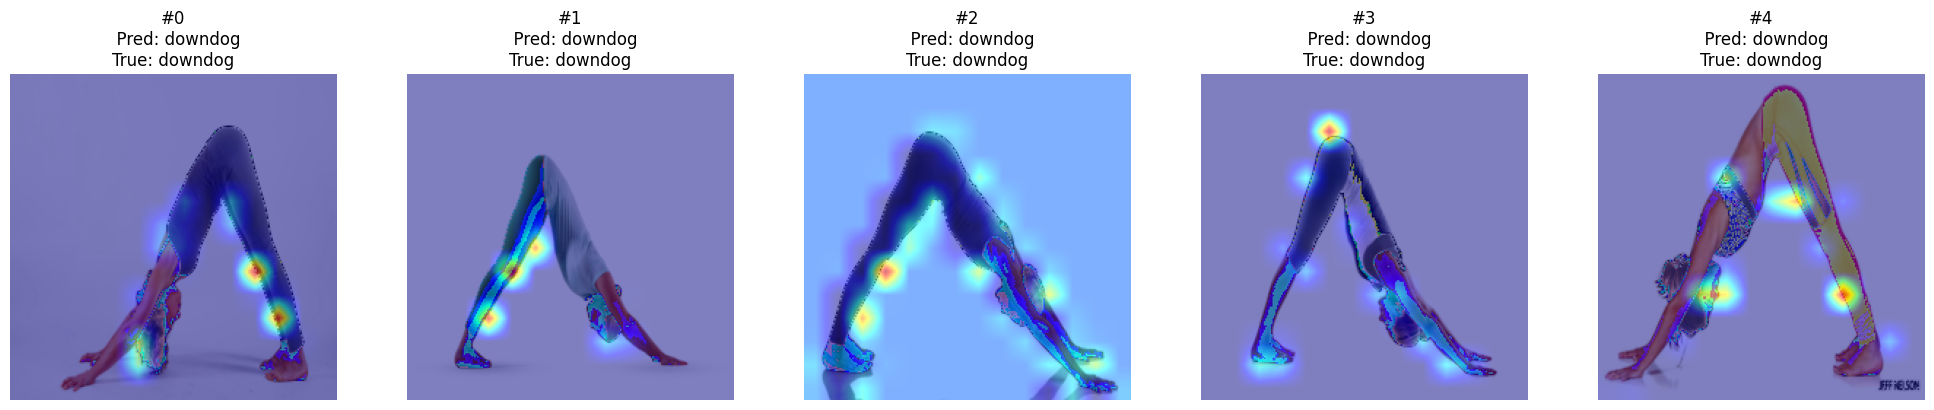

In [ ]:
model = load_model("vit", num_classes=5, model_path="best_vit_b16_finetune.pth")
test_acc = evaluate(model, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")
class_to_idx  = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
show_conv_proj_gradcam_vit(model,test_dataset,idx_to_class,device,n=5,start=0)

### DinoV2

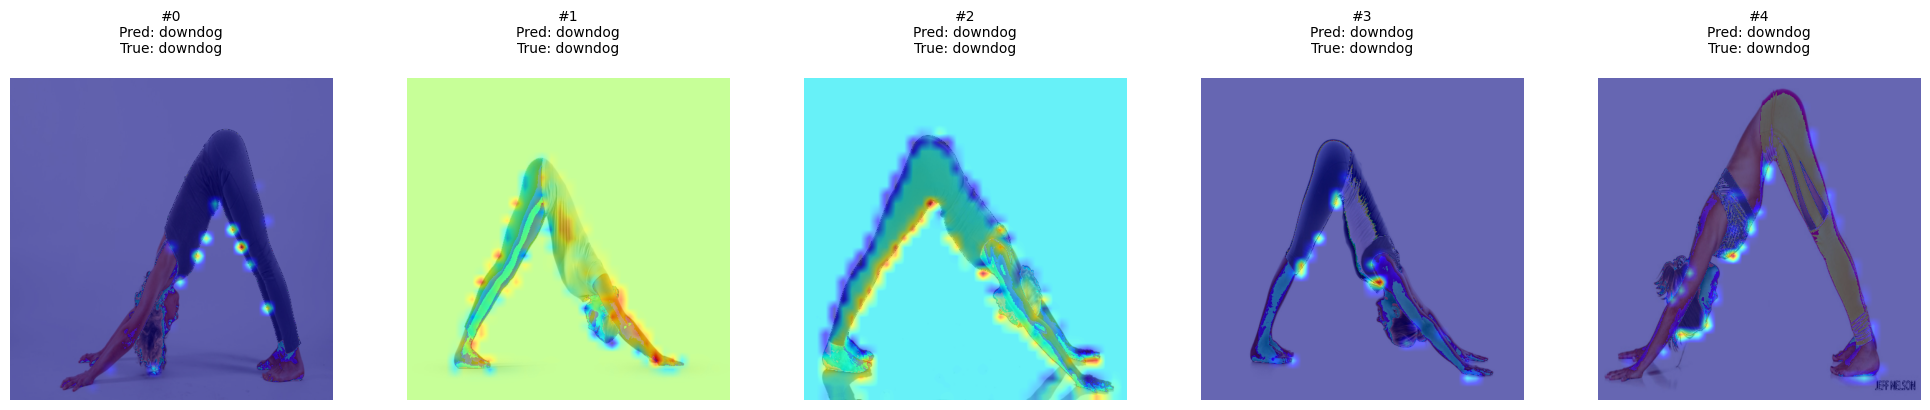

In [ ]:
model = load_model("dinov2", num_classes=5, model_path="best_dinov2_vit_b14.pth")
model = model.to(device)
# prepare mapping from idx to class name
class_to_idx  = full_dataset.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

show_dinov2_gradcam(model,test_dataset,idx_to_class,device,n=5,start=0,threshold=0)

### PoseGNN

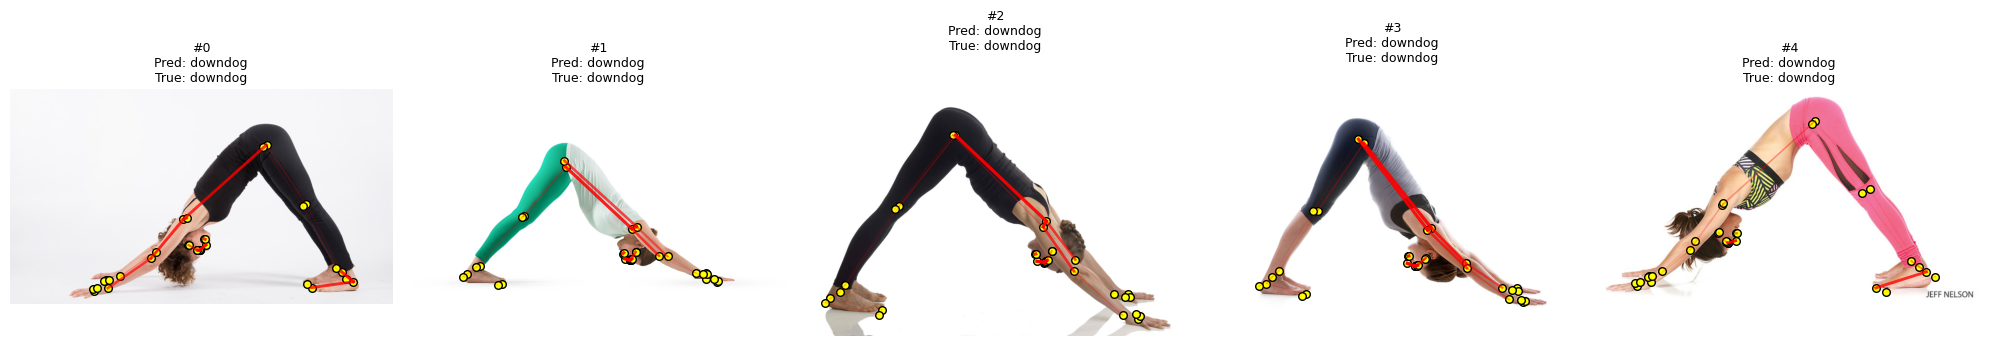

In [ ]:
test_ds = PoseGraphDataset("test_keypoints.json", train=False)
show_pose_explainer_row(test_ds, explainer, start=0, n=5, threshold=0.1)


# Noise Robustness

### All Models

Running simplecnn...
[best_simplecnn.pth] Accuracy on noisy test set (std=0.0): 77.66%
[best_simplecnn.pth] Accuracy on noisy test set (std=0.05): 77.02%
[best_simplecnn.pth] Accuracy on noisy test set (std=0.1): 76.17%
[best_simplecnn.pth] Accuracy on noisy test set (std=0.15): 72.98%
[best_simplecnn.pth] Accuracy on noisy test set (std=0.2): 63.62%
Running googlenet...
[best_googlenet_50e.pth] Accuracy on noisy test set (std=0.0): 97.66%
[best_googlenet_50e.pth] Accuracy on noisy test set (std=0.05): 96.81%
[best_googlenet_50e.pth] Accuracy on noisy test set (std=0.1): 91.49%
[best_googlenet_50e.pth] Accuracy on noisy test set (std=0.15): 84.68%
[best_googlenet_50e.pth] Accuracy on noisy test set (std=0.2): 77.87%
Running alexnet...
[best_alexnet_fullfinetune_50e.pth] Accuracy on noisy test set (std=0.0): 95.74%
[best_alexnet_fullfinetune_50e.pth] Accuracy on noisy test set (std=0.05): 95.96%
[best_alexnet_fullfinetune_50e.pth] Accuracy on noisy test set (std=0.1): 92.13%
[best_alexn

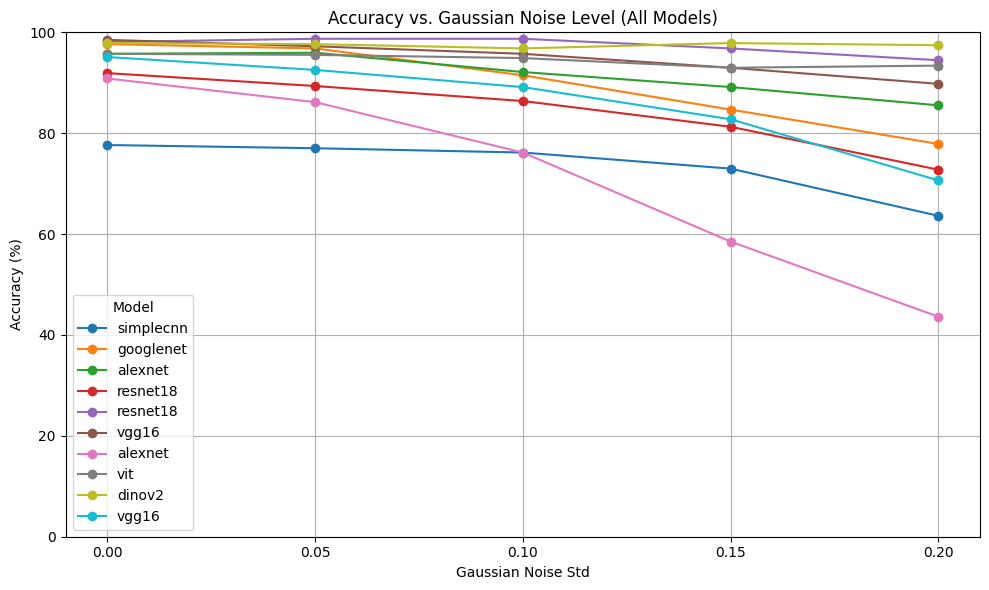

In [ ]:
models_folder = "./models/"  # Replace with your actual folder
test_dir = "yoga_aayush/DATASET/TEST"  # Replace with your test dataset path
num_classes = 5  # Update to your actual number of classes
class_names = ["downdog", "goddess", "plank", "tree", "warrior2"]

run_on_all_models(models_folder, test_dir, num_classes, class_names)


### Divide to groups

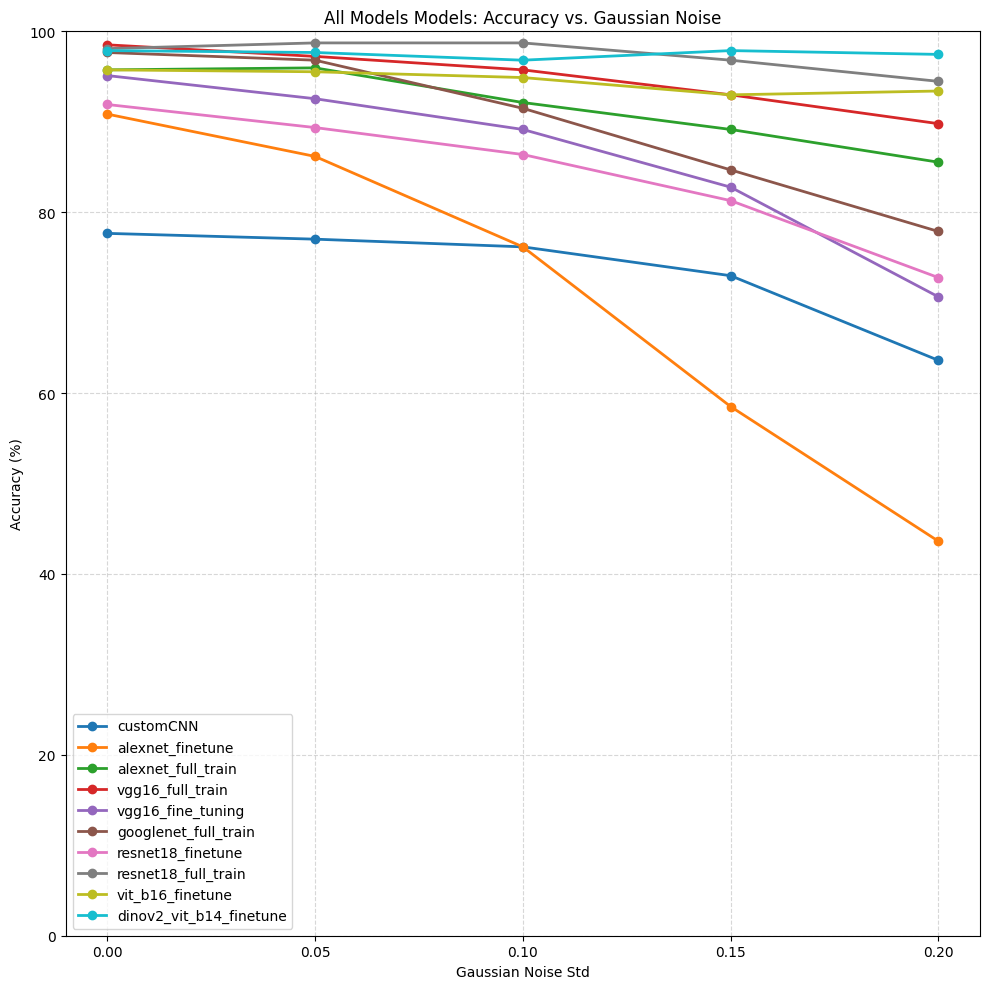

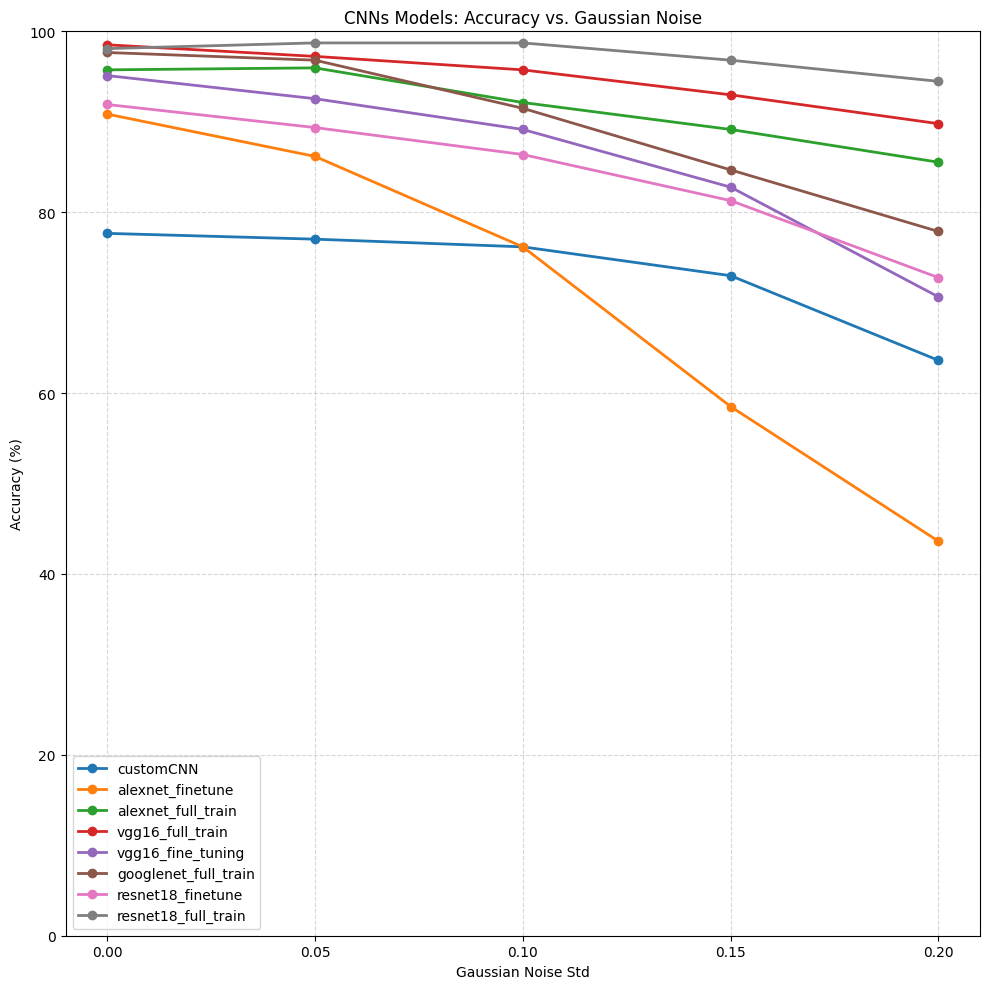

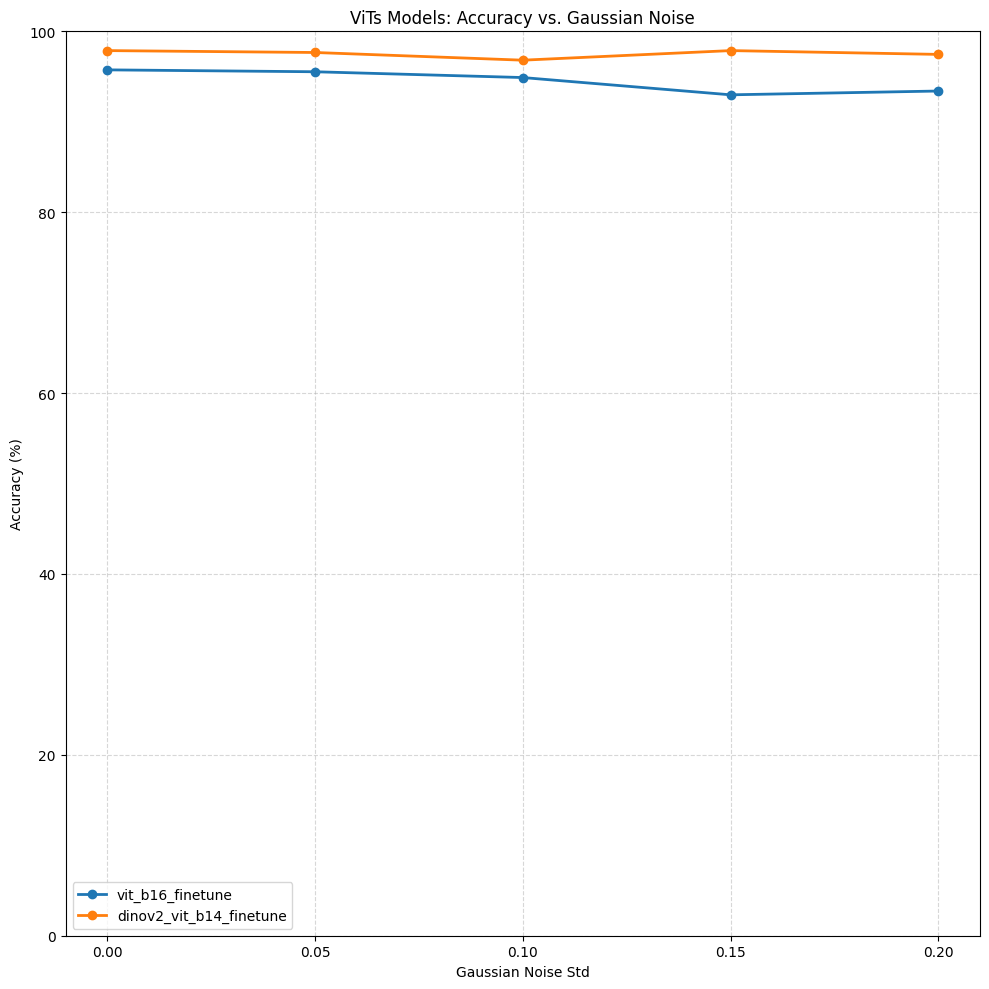

In [ ]:
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

all_accuracies = {
    "customCNN": [77.66, 77.02, 76.17, 72.98, 63.62],
    "googlenet_full_train": [97.66, 96.81, 91.49, 84.68, 77.87],
    "alexnet_full_train": [95.74, 95.96, 92.13, 89.15, 85.53],
    "resnet18_finetune": [91.91, 89.36, 86.38, 81.28, 72.77],
    "resnet18_full_train": [98.09, 98.72, 98.72, 96.81, 94.47],
    "vgg16_full_train": [98.51, 97.23, 95.74, 92.98, 89.79],
    "alexnet_finetune": [90.85, 86.17, 76.17, 58.51, 43.62],
    "vit_b16_finetune": [95.74, 95.53, 94.89, 92.98, 93.40],
    "dinov2_vit_b14_finetune": [97.87, 97.66, 96.81, 97.87, 97.45],
    "vgg16_fine_tuning": [95.11, 92.55, 89.15, 82.77, 70.64],
}

model_groups = {
    "All Models":["customCNN", "alexnet_finetune", "alexnet_full_train","vgg16_full_train",
             "vgg16_fine_tuning","googlenet_full_train","resnet18_finetune", "resnet18_full_train",
             "vit_b16_finetune", "dinov2_vit_b14_finetune"],
    "CNNs": ["customCNN", "alexnet_finetune", "alexnet_full_train","vgg16_full_train",
             "vgg16_fine_tuning","googlenet_full_train","resnet18_finetune", "resnet18_full_train"],
    "ViTs": ["vit_b16_finetune", "dinov2_vit_b14_finetune"],

}

for group_name, model_names in model_groups.items():
    plt.figure(figsize=(10, 10))
    for model_name in model_names:
        if model_name in all_accuracies:
            plt.plot(
                noise_levels,
                all_accuracies[model_name],
                marker='o',
                linewidth=2,
                label=model_name

            )
    plt.title(f"{group_name} Models: Accuracy vs. Gaussian Noise")
    plt.xlabel("Gaussian Noise Std")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(noise_levels)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{group_name.lower()}_accuracy_vs_noise.png", dpi=300)
    plt.show()


In [ ]:
# Custom color palette (from ColorBrewer / Set2)
custom_colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#17becf",  # cyan
    "#bcbd22",  # yellow-green
]

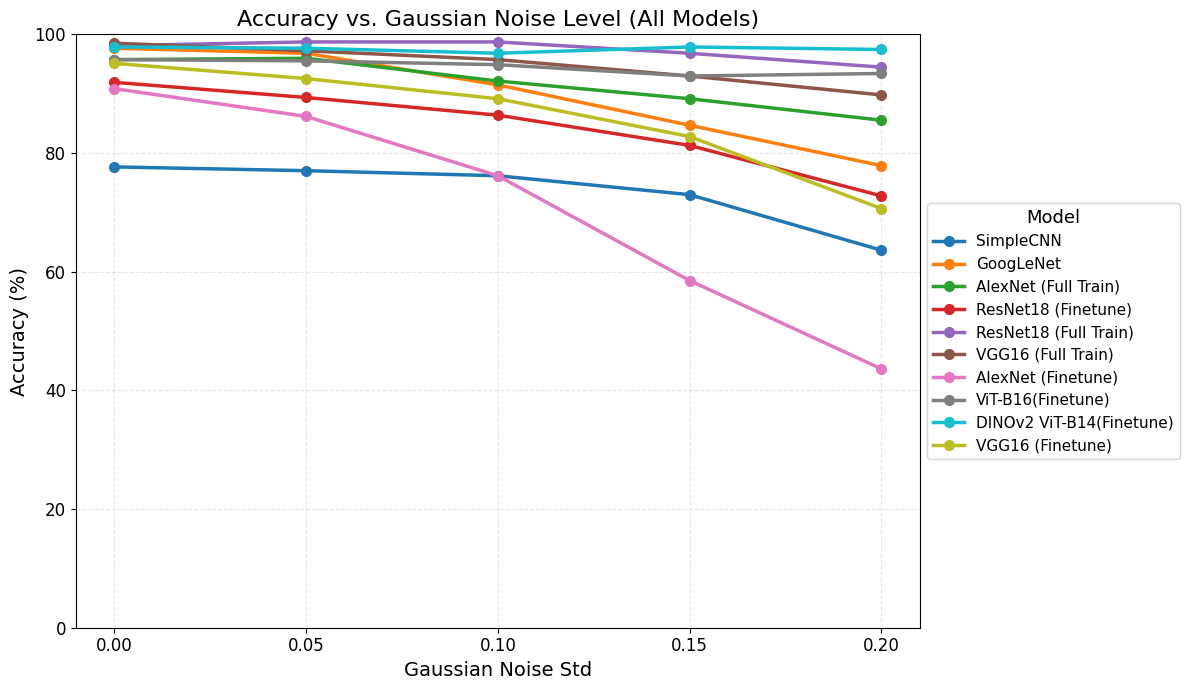

In [ ]:
import matplotlib.pyplot as plt

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

all_accuracies = {
    "simplecnn": [77.66, 77.02, 76.17, 72.98, 63.62],
    "googlenet": [97.66, 96.81, 91.49, 84.68, 77.87],
    "alexnet_fullfinetune_50e": [95.74, 95.96, 92.13, 89.15, 85.53],
    "resnet18_yoga_100e": [91.91, 89.36, 86.38, 81.28, 72.77],
    "resnet18_yoga_50e_with_fix": [98.09, 98.72, 98.72, 96.81, 94.47],
    "vgg16_50e_fix": [98.51, 97.23, 95.74, 92.98, 89.79],
    "alexnet_finetune_50e": [90.85, 86.17, 76.17, 58.51, 43.62],
    "vit_b16_finetune": [95.74, 95.53, 94.89, 92.98, 93.40],
    "dinov2_vit_b14": [97.87, 97.66, 96.81, 97.87, 97.45],
    "vgg16_yoga_50e_headonly": [95.11, 92.55, 89.15, 82.77, 70.64],
}


# Define pretty display names
pretty_names = {
    "simplecnn": "SimpleCNN",
    "googlenet": "GoogLeNet",
    "alexnet_fullfinetune_50e": "AlexNet (Full Train)",
    "resnet18_yoga_100e": "ResNet18 (Finetune)",
    "resnet18_yoga_50e_with_fix": "ResNet18 (Full Train)",
    "vgg16_50e_fix": "VGG16 (Full Train)",
    "alexnet_finetune_50e": "AlexNet (Finetune)",
    "vit_b16_finetune": "ViT-B16(Finetune)",
    "dinov2_vit_b14": "DINOv2 ViT-B14(Finetune)",
    "vgg16_yoga_50e_headonly": "VGG16 (Finetune)",
}



def plot_all_models_curves(all_accuracies, noise_levels):
    plt.figure(figsize=(12, 7))

    for i, (model_key, accs) in enumerate(all_accuracies.items()):
        color = custom_colors[i % len(custom_colors)]
        label = pretty_names.get(model_key, model_key)
        plt.plot(
            noise_levels, accs,
            label=label,
            marker='o',
            linewidth=2.5,
            markersize=7,
            color=color
        )

    plt.title("Accuracy vs. Gaussian Noise Level (All Models)", fontsize=16)
    plt.xlabel("Gaussian Noise Std", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.xticks(noise_levels, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(title="Model", fontsize=11, title_fontsize=13, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.savefig("accuracy_vs_noise_custom_colors.png", dpi=300)
    plt.show()

# Run the function
plot_all_models_curves(all_accuracies, noise_levels)


### comparison between fine tune to full training

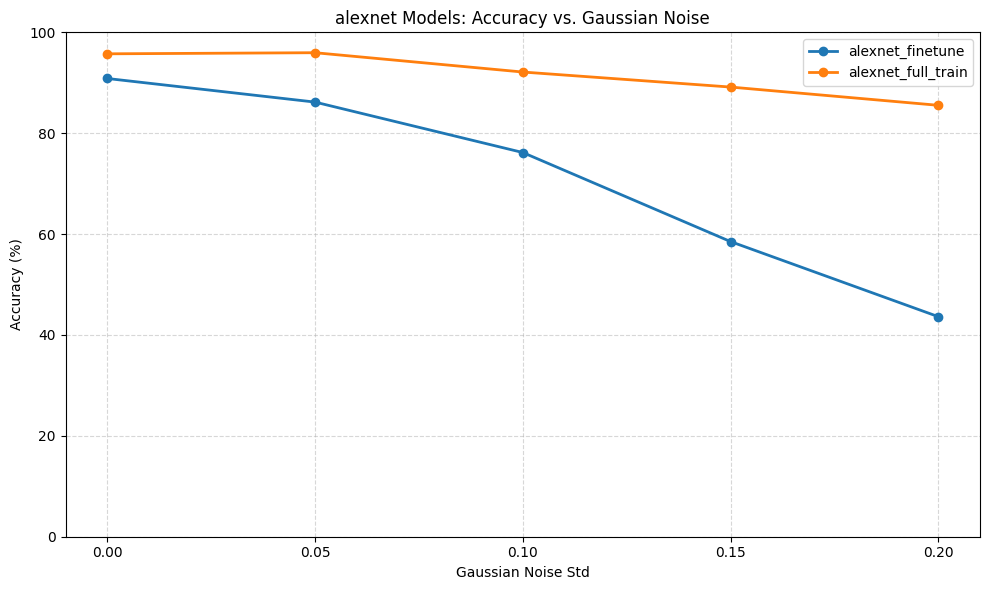

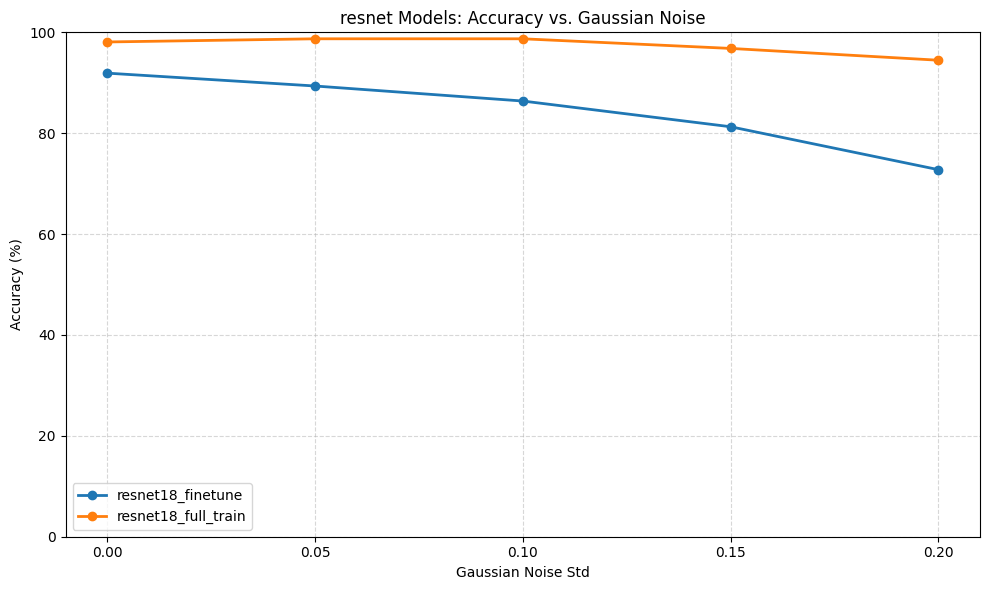

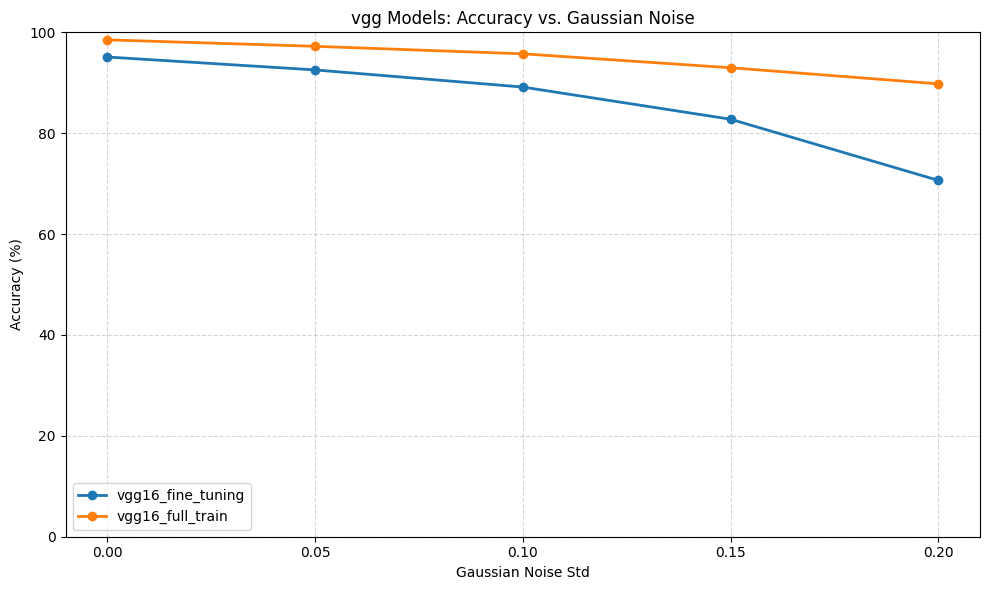

In [ ]:
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

all_accuracies = {
    "customCNN": [77.66, 77.02, 76.17, 72.98, 63.62],
    "googlenet_full_train": [97.66, 96.81, 91.49, 84.68, 77.87],
    "alexnet_full_train": [95.74, 95.96, 92.13, 89.15, 85.53],
    "resnet18_finetune": [91.91, 89.36, 86.38, 81.28, 72.77],
    "resnet18_full_train": [98.09, 98.72, 98.72, 96.81, 94.47],
    "vgg16_full_train": [98.51, 97.23, 95.74, 92.98, 89.79],
    "alexnet_finetune": [90.85, 86.17, 76.17, 58.51, 43.62],
    "vit_b16_finetune": [95.74, 95.53, 94.89, 92.98, 93.40],
    "dinov2_vit_b14_finetune": [97.87, 97.66, 96.81, 97.87, 97.45],
    "vgg16_fine_tuning": [95.11, 92.55, 89.15, 82.77, 70.64],
}

model_groups = {
    "alexnet": ["alexnet_finetune", "alexnet_full_train"],
    "resnet":["resnet18_finetune","resnet18_full_train"],
    "vgg": ["vgg16_fine_tuning","vgg16_full_train"],

}

for group_name, model_names in model_groups.items():
    plt.figure(figsize=(10, 6))
    for model_name in model_names:
        if model_name in all_accuracies:
            plt.plot(
                noise_levels,
                all_accuracies[model_name],
                marker='o',
                linewidth=2,
                label=model_name

            )
    plt.title(f"{group_name} Models: Accuracy vs. Gaussian Noise")
    plt.xlabel("Gaussian Noise Std")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(noise_levels)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{group_name.lower()}_accuracy_vs_noise.png", dpi=300)
    plt.show()


### poseGNN

Accuracy on noisy test set (std=0.0): 87.74%
Accuracy on noisy test set (std=0.05): 87.10%
Accuracy on noisy test set (std=0.1): 82.37%
Accuracy on noisy test set (std=0.15): 75.91%
Accuracy on noisy test set (std=0.2): 66.02%


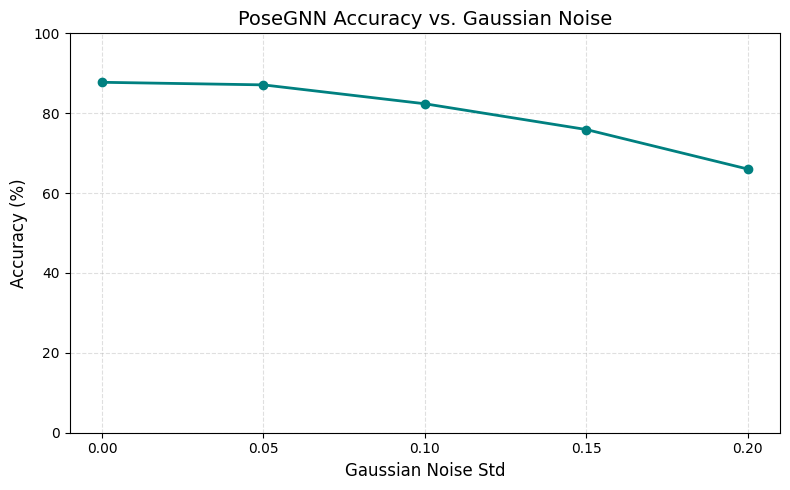

In [ ]:
test_dataset = PoseGraphDataset("test_keypoints.json")

plot_accuracy_vs_noise_posegnn(
    model_path="best_poseGNN_50e.pth",
    model_class=PoseGNN,
    test_dataset=test_dataset,
    noise_levels=[0.0, 0.05, 0.1, 0.15, 0.2]
)